# **Machine Learning:** FNN Model 

- **NYC Taxi Fare Prediction**
This project presents a machine learning approach to predicting the total fare amount of NYC taxi trips. By combining structured trip data — including pickup/dropoff locations, time of day, distance, and passenger details — with deep learning techniques and embedding layers for categorical variables, the model captures complex fare patterns across the city. The final architecture achieves strong predictive performance, offering practical applications for passengers, policymakers, and urban mobility planners.

**Problem Framing:**

- Define the business goal: Predict total taxi fare using trip-related features
- Identify the target variable: total_amount
- Choose an appropriate modeling task: Supervised Regression

- Why Use a Deep Learning FNN Model?
    - Handles Mixed Feature Types with embedding layers
    - Flexible with Irregular Patterns
    - Scalable to Future Enhancements

**- What Are Embeddings?**
- An embedding is a learned, dense vector representation of a categorical variable
- Why Are Embeddings Powerful?
    - Efficient for High Cardinality
        - One-hot for PULocationID with 200+ values → huge sparse vector, label encoding (loses relationships between categories)
        - Embedding turns it into a small, dense vector (e.g. 16 values).
    - Captures Similarity : The model learns that location A and B have similar fare patterns → gives them similar embeddings.
    - Can Generalize Better: Nearby locations or vendors with similar behavior share learned features.

**- Model Building Process** – NYC Taxi Fare Prediction:

- Dataset Integration &Feature Selection:
    - Unified schemas and cleaned records
    - Ensured consistent column types and value interpretation
    - Dropped irrelevant, redundant, or inconsistent columns
    - Selected only reliable and predictive features for modeling
- Target Separation & Stratified Splitting
    - Defined total_amount as the target variable
    - Applied Stratified Train/Validation/Test Split to preserve fare distribution
- Feature Grouping Strategy.Why Embeddings?
    - Numerical features: trip stats, speed, time of day
    - Categorical features: encoded using embeddings for high-cardinality fields (e.g. PULocationID)
    - Binary & one-hot features: weekend, congestion, dataset source
- Model Architecture Design – Keras Functional API
    - Handled multiple input types (dense + embedding)
    - Merged features, passed through hidden layers
    - Output: single regression node to predict total fare
- Model Training & Optimization
    - Used MSE loss, Adam optimizer, and early stopping
- Model Evaluation & Testing
    - Overall Model Performance and Interpretation
- Future Enhancement:
    - Tuned hyperparameters (dropout, L2, learning rate) to improve generalization

## **Import Dependencies**

In [1]:
# === Core Libraries ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# === TensorFlow + Keras ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# === Visualization (optional but useful) ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Warnings clean-up ===
import warnings
warnings.filterwarnings("ignore")



In [2]:
# === File Import + Reporting ===
def load_and_report_csv(file_path, dataset_name='Unknown'):
    """
    Load a CSV file and print summary information for exploration.
    
    Parameters:
        file_path (str): Path to the CSV file
        dataset_name (str): Optional name to tag the dataset (e.g., 'Yellow')
    
    Returns:
        pd.DataFrame: Loaded DataFrame with basic reporting
    """
    print(f"\n📂 Loading {dataset_name} dataset from: {file_path}")
    
    df = pd.read_csv(file_path)

    print("\n✅ Data successfully loaded!")
    print(f"🔢 Shape: {df.shape}")
    print("\n🧾 Column Types:")
    print(df.dtypes)
    
    print("\n🔍 First 5 Rows:")
    print(df.head())

    print("\n📊 Statistical Summary (Numerical Columns):")
    print(df.describe())

    print("\n📉 Missing Values:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

    # Add dataset name as a column to distinguish sources if needed
    df['source'] = dataset_name
    
    return df

yellow_df = load_and_report_csv("analysis_ready\yellow_ready_ml.csv", "Yellow")
green_df = load_and_report_csv("analysis_ready\green_ready_ml.csv", "Green")



📂 Loading Yellow dataset from: analysis_ready\yellow_ready_ml.csv

✅ Data successfully loaded!
🔢 Shape: (1979285, 37)

🧾 Column Types:
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
Airport_fee              float64
pickup_date               object
PU_Borough                object
PU_Zone                   object
PU_ServiceZone            object
DO_Borough                object
DO_Zone                   object
DO_ServiceZone            object
durati

## **1- Dataset Integration & Feature Selection:**

**A- Preprocessing Step: Dropping Unused Columns**

We drop columns that are:

- ✅ Specific to one source only (e.g., `Airport_fee`, `trip_type`)
- ✅ raw datetime columns (`tpep_*`, `lpep_*`, and `pickup/dropoff_datetime`)
- ✅ Fare components that would leak the target label (`fare_amount`, `tip_amount`, etc.)
- ✅ Redundant location descriptions — we use only PU/DO Location IDs
- ✅ Duplicate features like `trip_dayofweek` (we already have `pickup_dayofweek`)

We also tag each row with a `source` column (either `'yellow'` or `'green'`).


In [3]:
def drop_unneeded_columns(df, source_type):
    """
    Drops unnecessary columns for fare prediction.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame (Yellow or Green taxi).
        source_type (str): Either 'yellow' or 'green'.
        
    Returns:
        pd.DataFrame: Cleaned DataFrame ready for preprocessing.
    """

    # Columns unique to only one dataset
    unique_columns = {
        'yellow': ['Airport_fee'],
        'green': ['trip_type']
    }

    # Redundant datetime and location columns
    datetime_columns = [
        'pickup_date', 'pickup_datetime', 'dropoff_datetime',
        'tpep_pickup_datetime', 'tpep_dropoff_datetime',
        'lpep_pickup_datetime', 'lpep_dropoff_datetime'
    ]
    
    location_desc_columns = [
        'PU_Borough', 'PU_Zone', 'PU_ServiceZone',
        'DO_Borough', 'DO_Zone', 'DO_ServiceZone'
    ]
    
    fare_components = [
        'fare_amount', 'extra', 'mta_tax', 'tip_amount',
        'tolls_amount', 'improvement_surcharge',
        'congestion_surcharge','fare_per_mile','fare_per_minute'
    ]
    
    

    others_to_drop = ['trip_dayofweek', 'store_and_fwd_flag']

    # Combine all drop targets
    drop_list = (
        datetime_columns +
        location_desc_columns +
        fare_components +
        others_to_drop +
        unique_columns.get(source_type.lower(), [])
    )

    # Drop only existing columns
    for col in drop_list:
        if col in df.columns:
            df = df.drop(columns=[col])
    
    # Add source type (yellow or green)
    df['source'] = source_type.lower()
    
    return df

yellow_df = drop_unneeded_columns(yellow_df, 'yellow')
green_df = drop_unneeded_columns(green_df, 'green')

In [4]:
yellow_df.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'total_amount',
       'duration_inMin', 'average_speed', 'pickup_hour', 'pickup_dayofweek',
       'pickup_month', 'dropoff_hour', 'is_weekend', 'median_speed',
       'is_congestion', 'source'],
      dtype='object')

In [5]:
print(green_df.columns)

Index(['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'total_amount', 'payment_type',
       'duration_inMin', 'average_speed', 'pickup_hour', 'pickup_dayofweek',
       'pickup_month', 'dropoff_hour', 'is_weekend', 'median_speed',
       'is_congestion', 'source'],
      dtype='object')


In [6]:
def combine_datasets(yellow_df, green_df):
    """
    Concatenates cleaned yellow and green taxi DataFrames into one unified DataFrame.
    Ensures both DataFrames have the same columns in the same order.

    Parameters:
        yellow_df (pd.DataFrame): Cleaned Yellow Taxi DataFrame with 'source' = 'yellow'
        green_df (pd.DataFrame): Cleaned Green Taxi DataFrame with 'source' = 'green'

    Returns:
        pd.DataFrame: Combined DataFrame with consistent column order and reset index.
    """
    yellow_df = yellow_df.copy()
    green_df = green_df.copy()
    
    # Get ordered list of columns that are common to both
    common_cols = [col for col in yellow_df.columns if col in green_df.columns]
    
    # Align both DataFrames to same columns and same order
    yellow_df = yellow_df[common_cols]
    green_df = green_df[common_cols]
    
    # Concatenate and reset index
    combined_df = pd.concat([yellow_df, green_df], axis=0).reset_index(drop=True)
    
    return combined_df
taxi = combine_datasets(yellow_df, green_df)

print(taxi.columns)
taxi.head()

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'total_amount',
       'duration_inMin', 'average_speed', 'pickup_hour', 'pickup_dayofweek',
       'pickup_month', 'dropoff_hour', 'is_weekend', 'median_speed',
       'is_congestion', 'source'],
      dtype='object')


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,duration_inMin,average_speed,pickup_hour,pickup_dayofweek,pickup_month,dropoff_hour,is_weekend,median_speed,is_congestion,source
0,1,1.0,0.955511,99.0,230,43,0.0,2.842581,1.606099,3.222885,12,0,1,12,False,2.132367,False,yellow
1,2,3.0,0.810930,1.0,164,229,1.0,3.279406,2.975530,1.615869,0,0,1,1,False,2.465489,True,yellow
2,2,2.0,1.327075,1.0,43,164,2.0,3.265759,3.171085,2.113702,14,0,1,15,False,2.182831,False,yellow
3,1,1.0,0.336472,1.0,186,100,1.0,2.580217,2.155631,1.421687,3,0,1,3,False,2.677125,True,yellow
4,1,2.0,2.151762,1.0,48,255,1.0,4.201703,3.620779,2.605571,2,0,1,2,False,2.669392,False,yellow


In [7]:
taxi['source'].describe()

count     2010154
unique          2
top        yellow
freq      1979285
Name: source, dtype: object

In [8]:
taxi['total_amount'].describe(include= all)

count    2.010154e+06
mean     3.177749e+00
std      5.090678e-01
min      0.000000e+00
25%      2.830858e+00
50%      3.091042e+00
75%      3.425890e+00
max      6.332124e+00
Name: total_amount, dtype: float64

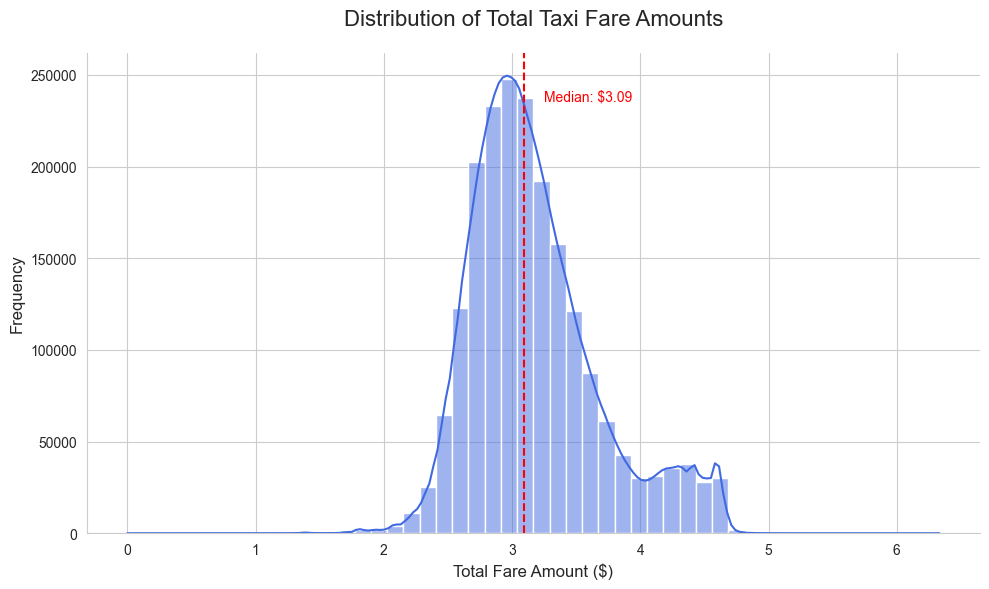

In [9]:

# Set Seaborn style
sns.set_style("whitegrid")

# Plot histogram with KDE
plt.figure(figsize=(10, 6))
ax = sns.histplot(taxi['total_amount'], bins=50, kde=True, color='royalblue')

# Add title and axis labels
plt.title('Distribution of Total Taxi Fare Amounts', fontsize=16, pad=20)
plt.xlabel('Total Fare Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add median line
median_fare = taxi['total_amount'].median()
ax.axvline(median_fare, color='red', linestyle='--', linewidth=1.5)
ax.text(median_fare * 1.05, ax.get_ylim()[1] * 0.9,
        f'Median: ${median_fare:.2f}',
        color='red', fontsize=10)

# Clean up visual clutter
sns.despine()
plt.tight_layout()
plt.show()


-**RatecodeID mapping**
The **RatecodeID**is a categorical feature contains non-consecutive integer codes, including a special value 99 representing unknown or null categories. To prepare this feature for embedding layers, which require zero-based contiguous indices, we map the original codes to a dense range starting at 0. This ensures that the embedding input dimension matches the number of unique categories and **prevents out-of-range errors** during training. The mapping preserves all categories while providing a compact and consistent index representation.

In [10]:
def ratecode_id_mapping(df) :
    # 3. Map RatecodeID to zero-based dense IDs
    ratecode_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 99: 6}
    df['RatecodeID_mapped'] = df['RatecodeID'].map(ratecode_map)
    df = df.drop(columns=['RatecodeID'])  # clean df
    return df
taxi = ratecode_id_mapping(taxi)


In [11]:
taxi.describe()

,VendorID,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,duration_inMin,average_speed,pickup_hour,pickup_dayofweek,pickup_month,dropoff_hour,median_speed,RatecodeID_mapped
count,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06,2.010154e+06
mean,1.765418e+00,1.306388e+00,1.163507e+00,1.637657e+02,1.635856e+02,1.102848e+00,3.177749e+00,2.621643e+00,2.343937e+00,1.429904e+01,3.026791e+00,6.641287e+00,1.434611e+01,2.343010e+00,6.648068e-01
std,4.243123e-01,7.690681e-01,6.259341e-01,6.493699e+01,6.927987e+01,6.301948e-01,5.090678e-01,6.493987e-01,4.653652e-01,5.836687e+00,1.934413e+00,3.441126e+00,5.946487e+00,2.853705e-01,1.841147e+00
min,1.000000e+00,1.000000e+00,9.950331e-03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,9.531018e-02,9.677495e-03,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,1.000000e+00,7.178398e-01,1.320000e+02,1.130000e+02,1.000000e+00,2.830858e+00,2.182299e+00,2.056960e+00,1.100000e+01,1.000000e+00,4.000000e+00,1.100000e+01,2.149833e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.011601e+00,1.610000e+02,1.620000e+02,1.000000e+00,3.091042e+00,2.627081e+00,2.322833e+00,1.500000e+01,3.000000e+00,7.000000e+00,1.500000e+01,2.290466e+00,0.000000e+00
75%,2.000000e+00,1.000000e+00,1.442202e+00,2.330000e+02,2.340000e+02,1.000000e+00,3.425890e+00,3.066501e+00,2.608021e+00,1.900000e+01,5.000000e+00,1.000000e+01,1.900000e+01,2.437061e+00,0.000000e+00
max,6.000000e+00,6.000000e+00,3.047376e+00,2.650000e+02,2.650000e+02,5.000000e+00,6.332124e+00,4.277129e+00,4.262680e+00,2.300000e+01,6.000000e+00,1.200000e+01,2.300000e+01,1.001784e+01,6.000000e+00


In [12]:
taxi.isna().sum()

VendorID             0
passenger_count      0
trip_distance        0
PULocationID         0
DOLocationID         0
payment_type         0
total_amount         0
duration_inMin       0
average_speed        0
pickup_hour          0
pickup_dayofweek     0
pickup_month         0
dropoff_hour         0
is_weekend           0
median_speed         0
is_congestion        0
source               0
RatecodeID_mapped    0
dtype: int64

## **2- Target Separation & Stratified Splitting**

### Split Features (X) and Target (y):
We want to train a model that predicts how much a passenger will pay for a taxi ride — based on the pickup and dropoff locations, time of day, distance, and other ride details. So we separate the known fare (total_amount) from the data that we’ll use to estimate it

In [13]:
# Step 1: Split the dataset into features and target
y = taxi['total_amount']   # 🎯 target variable
X = taxi.drop(columns=['total_amount'])  # input features only


In [14]:
X.columns


Index(['VendorID', 'passenger_count', 'trip_distance', 'PULocationID',
       'DOLocationID', 'payment_type', 'duration_inMin', 'average_speed',
       'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'dropoff_hour',
       'is_weekend', 'median_speed', 'is_congestion', 'source',
       'RatecodeID_mapped'],
      dtype='object')

In [15]:
y

0          2.842581
1          3.279406
2          3.265759
3          2.580217
4          4.201703
             ...   
2010149    3.952397
2010150    3.728581
2010151    3.648057
2010152    3.269949
2010153    2.772589
Name: total_amount, Length: 2010154, dtype: float64

### **Train/Test Split**

- 🎯 Stratified Train/Validation/Test Split for Logged Target

- Ensures that training, validation, and test datasets maintain the **same distribution** of the target variable — especially useful when:
    - The target is skewed (e.g., fare amount, trip duration).
    - A majority of samples fall in a few buckets, or where rare high values may otherwise be excluded from val/test sets.
-What it Does:
    - Uses `pd.qcut()` to bin the **target**  into quantile-based categories.
    - Applies `train_test_split()` with `stratify=` to keep consistent representation of all value ranges.
    - Returns: `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`

- 📤 Expected Output:
    - Properly stratified and shuffled splits — ready to feed into modeling pipelines — where validation and test sets reflect the **true** distribution of the original data.


In [16]:
from sklearn.model_selection import train_test_split
import pandas as pd

def stratified_split(X, y, test_size=0.2, val_size=0.25, q=10, random_state=42):
    """
    Perform stratified Train/Validation/Test split based on target variable bins (for imbalanced regression).

    Parameters:
        X (pd.DataFrame): Features
        y (pd.Series): Target variable (can be log-transformed or raw)
        test_size (float): Proportion for test set
        val_size (float): Proportion for validation set (from training portion)
        q (int): Number of quantile bins for stratification
        random_state (int): Seed for reproducibility

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """

    # Step 1: Bin entire y for stratification (on full set)
    y_bins_full = pd.qcut(y, q=q, duplicates='drop')

    # Step 2: Train+Val vs Test split (stratify on full bins)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y_bins_full,
        random_state=random_state
    )

    # Step 3: Re-bin y_train_full for train/val stratification
    y_bins_temp = pd.qcut(y_train_full, q=q, duplicates='drop')

    # Step 4: Final train/val split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=val_size,
        stratify=y_bins_temp,
        random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = stratified_split(X, y, test_size=0.2, val_size=0.25, q=10, random_state=42)

# Final shapes for verification
print("Train set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Train set size: 1206092
Validation set size: 402031
Test set size: 402031


Validation count: 402031
Test count: 402031
Proportion of full data:
Validation: 0.20000009949486458
Test: 0.20000009949486458


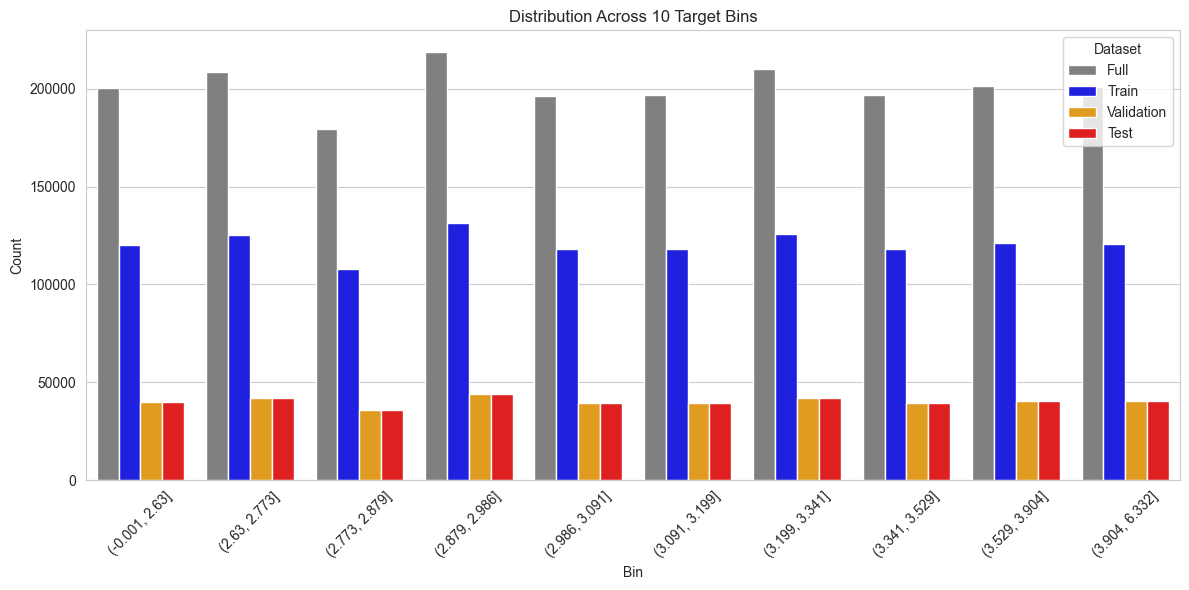

In [17]:
def plot_stratified_distribution(y, y_train, y_val, y_test, q=10):
    """
    Visualize the distribution of train/val/test sets across target bins.
    
    Parameters:
        y: Full target series
        y_train, y_val, y_test: Split target series
        q: Number of bins used in stratification
    """
    # Create consistent bins across all data
    bins = pd.qcut(y, q=q, duplicates='drop')
    bin_edges = bins.cat.categories
    
    # Create DataFrame for plotting
    plot_data = []
    
    for name, series in [('Full', y), 
                         ('Train', y_train),
                         ('Validation', y_val),
                         ('Test', y_test)]:
        # Bin each series using the same edges
        binned = pd.cut(series, bins=bin_edges)
        counts = binned.value_counts().sort_index()
        # Create a DataFrame for this set
        df = pd.DataFrame({
            'Bin': counts.index.astype(str),  # Convert intervals to strings
            'Count': counts.values,
            'Set': name
        })
        plot_data.append(df)
    
    plot_df = pd.concat(plot_data)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=plot_df, 
        x='Bin', 
        y='Count', 
        hue='Set',
        palette={'Full': 'gray', 'Train': 'blue', 
                'Validation': 'orange', 'Test': 'red'}
    )
    plt.title(f'Distribution Across {q} Target Bins')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()


print("Validation count:", len(y_val))  
print("Test count:", len(y_test))  
print("Proportion of full data:")  
print("Validation:", len(y_val) / len(y))  
print("Test:", len(y_test) / len(y))  

# Usage
plot_stratified_distribution(y, y_train, y_val, y_test, q=10)



## **3- Feature Grouping Strategy**

- **Why Embeddings ?**

### **- 📊 Feature Preparation Plan:**

- We divide our features into four types
    - **Numerical**: Continuous variables (scaled with `StandardScaler`)
    - **Categorical for Embedding**: Discrete categories like location and vendor IDs (encoded as integers, then passed to embedding layers)
    - **Binary**: Already 0/1 (used directly)
    - **One-Hot Encoded**: Categorical with few values (e.g. trip source: yellow/green)
- This separation helps build a neural model that can efficiently learn both numerical and categorical patterns. For high-cardinality categories, we use **embeddings** to avoid the downsides of one-hot encoding and let the model learn a dense, meaningful vector for each category.

In [18]:
# - Define feature groups:
# Feature type groups (important for processing and modeling)
numerical_features = [
    'passenger_count', 'trip_distance', 'duration_inMin',
    'average_speed', 'pickup_hour', 'pickup_dayofweek',
    'pickup_month', 'dropoff_hour', 'median_speed'
]

categorical_embed_features = [
    'RatecodeID_mapped', 'PULocationID',
    'DOLocationID', 'payment_type'
]

binary_features = ['is_weekend', 'is_congestion']
one_hot_features = ['source','VendorID']


- **🧠 What Are Embeddings (in our taxi model)?**

    - Embeddings are **dense vector representations** of categorical features.
    - Instead of using one-hot encoding (which creates large sparse arrays), we assign an **integer ID** to each category, and then map that ID to a **learnable vector** (e.g. 8-dimensional).
    -For example:
        - `PULocationID = 237` → [0.12, -0.45, 0.09, ..., 0.78]

    - This helps the model **learn spatial or behavioral similarities** between locations, vendors, or rate codes — something one-hot encoding can't do!

    In our model, we use embedding for:
        - `VendorID`
        - `RatecodeID`
        - `PULocationID`
        - `DOLocationID`
        - `payment_type`

    - These columns have **many unique values** but are **not ordinal**, making embeddings ideal.

    - ✅ Embeddings reduce dimensionality and improve performance for neural networks, especially when input features are IDs or categories.


In [19]:
# calculates optimal embedding sizes.
# define the embedding dimensions
# vocab_size = The total number of unique categories in your feature.
# emb_dim = The length of the vector used to represent each category.

embed_dims = {}
for col in categorical_embed_features:
    vocab_size = int(X_train[col].max()) + 1  # Use max value + 1, not nunique
    emb_dim = min(50, vocab_size // 2) # Floor division
    embed_dims[col] = (vocab_size, emb_dim)
# ...existing code...
print("✅ Embedding dimensions:")
print(embed_dims)

✅ Embedding dimensions:
{'RatecodeID_mapped': (7, 3), 'PULocationID': (266, 50), 'DOLocationID': (266, 50), 'payment_type': (6, 3)}


In [20]:
import pandas as pd

stats = []
for col in categorical_embed_features:
    max_val = X_train[col].max()
    unique_count = X_train[col].nunique()
    vocab_size = int(max_val) + 1
    emb_dim = min(50, vocab_size//2)
    
    stats.append({
        'Column': col,
        'Max Value': max_val,
        'Unique Values': unique_count,
        'Vocab Size': vocab_size,
        'Embed Dim': emb_dim
    })

stats_df = pd.DataFrame(stats)
print("\n📊 Categorical Features Summary:")
display(stats_df)  # or print(stats_df.to_string())


📊 Categorical Features Summary:


,Column,Max Value,Unique Values,Vocab Size,Embed Dim
0,RatecodeID_mapped,6.0,6,7,3
1,PULocationID,265.0,252,266,50
2,DOLocationID,265.0,255,266,50
3,payment_type,5.0,6,6,3


In [21]:
for col in categorical_embed_features:
    max_val = X_train[col].max()
    unique_count = X_train[col].nunique()
    vocab_size = int(max_val) + 1
    
    print(f"\n=== {col} ===")
    print(f"• Max: {max_val} | Unique: {unique_count} | Vocab: {vocab_size}")
    print("Top 10 most frequent values:")
    print(X_train[col].value_counts().head(10))


=== RatecodeID_mapped ===
• Max: 6 | Unique: 6 | Vocab: 7
Top 10 most frequent values:
RatecodeID_mapped
0    1045673
6     125699
1      29931
4       2852
3       1057
2        880
Name: count, dtype: int64

=== PULocationID ===
• Max: 265 | Unique: 252 | Vocab: 266
Top 10 most frequent values:
PULocationID
237    56626
161    56576
236    51381
132    43396
162    41902
186    40251
230    40137
142    38753
138    36992
170    34757
Name: count, dtype: int64

=== DOLocationID ===
• Max: 265 | Unique: 255 | Vocab: 266
Top 10 most frequent values:
DOLocationID
236    54594
237    51489
161    45337
230    37888
170    36024
162    34960
142    33766
239    33125
68     31827
141    31399
Name: count, dtype: int64

=== payment_type ===
• Max: 5.0 | Unique: 6 | Vocab: 6
Top 10 most frequent values:
payment_type
1.0    902013
2.0    163187
0.0    113971
4.0     19888
3.0      6340
5.0       693
Name: count, dtype: int64


- Value Range Coverage Analysis for Embedding Features: This metric (Value_Range_Coverage) shows the proportion of unique values actually used in the dataset compared to the total vocabulary size defined for each embedding feature. A high coverage indicates that most categories are represented in the data, making the embedding layer more effective and meaningful.

In [22]:
stats_df['Value_Range_Coverage'] = stats_df['Unique Values'] / stats_df['Vocab Size']
print("\n🔍 Value Coverage Check:")
print(stats_df[['Column', 'Value_Range_Coverage']])


🔍 Value Coverage Check:
              Column  Value_Range_Coverage
0  RatecodeID_mapped              0.857143
1       PULocationID              0.947368
2       DOLocationID              0.958647
3       payment_type              1.000000


### **Prepares features for the RNN model:**

    Scaling numerical features

    Keeping binary features as-is

    One-hot encoding low-cardinality categorical features

    Preparing high-cardinality categorical features for embedding

    Combining all dense features (numerical + binary + one-hot)

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

def prepare_features(X, y=None, scaler=None, ohe=None, fit=True):
    
    """
    Prepares input features for training or inference in a neural network model.

    Parameters:
    -----------
    X : pandas.DataFrame
        Input dataframe containing raw feature columns.
    y : array-like or None
        Target variable (e.g., total fare amount). If None, only features are processed.
    scaler : sklearn.preprocessing.StandardScaler or None
        Fitted scaler for numerical features (used during inference).
    ohe : sklearn.preprocessing.OneHotEncoder or None
        Fitted one-hot encoder for low-cardinality categorical features.
    fit : bool
        Whether to fit transformers (scaler and encoder) or reuse existing ones.

    Returns:
    --------
    dict :
        {
            'X_dense': np.ndarray - processed numerical + binary + one-hot features,
            'X_embed': np.ndarray - raw categorical features for embeddings,
            'y': np.ndarray or None - target variable (if provided),
            'scaler': fitted StandardScaler,
            'one_hot_encoder': fitted OneHotEncoder
        }
    """

    # --- Numerical scaling
    if fit or scaler is None:
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X[numerical_features])
    else:
        X_num = scaler.transform(X[numerical_features])

    # --- Binary features
    X_bin = X[binary_features].values

    # --- One-hot encoding
    if fit or ohe is None:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_ohe = ohe.fit_transform(X[one_hot_features])
    else:
        X_ohe = ohe.transform(X[one_hot_features])

    # --- Embedding features
    X_embed = X[categorical_embed_features].astype('int32')

    # --- Combine dense inputs
    X_dense = np.hstack([X_num, X_bin, X_ohe])

    if y is not None:
        y_array = np.asarray(y).reshape(-1)
    else:
        y_array = None

    return {
        'X_dense': X_dense,
        'X_embed': X_embed,
        'y': y_array,
        'scaler': scaler,
        'one_hot_encoder': ohe
    }

# Prepare train/val/test data
train_data = prepare_features(X_train, y_train, fit=True)
val_data = prepare_features(X_val, y_val, scaler=train_data['scaler'], ohe=train_data['one_hot_encoder'], fit=False)
test_data = prepare_features(X_test, y_test, scaler=train_data['scaler'], ohe=train_data['one_hot_encoder'], fit=False)


In [24]:
#Verify Feature Dimensions
#X_dense.shape == (n_samples, total_dense_features)

print(f"Dense features: {train_data['X_dense'].shape}")
print(f"Embed features: {train_data['X_embed'].shape}")

Dense features: (1206092, 16)
Embed features: (1206092, 4)


In [25]:
#  Create input dictionaries with correct names
# - This snippet restructures the preprocessed data from prepare_features() into the exact format required by your neural network's input layers. It:
#   - Creates separate dictionary entries for each embedding feature
#   - Ensures proper array shapes for Keras
#   - Maintains consistency between train/val/test sets


X_train_inputs = {
    **{f"{col}_input": train_data['X_embed'][col].values.reshape(-1, 1)
       for col in categorical_embed_features},
    'dense_input': train_data['X_dense']
}

X_val_inputs = {
    **{f"{col}_input": val_data['X_embed'][col].values.reshape(-1, 1)
       for col in categorical_embed_features},
    'dense_input': val_data['X_dense']
}

X_test_inputs = {
    **{f"{col}_input": test_data['X_embed'][col].values.reshape(-1, 1)
       for col in categorical_embed_features},
    'dense_input': test_data['X_dense']
}

y_train_final = train_data['y']
y_val_final = val_data['y']
y_test_final = test_data['y']

In [26]:
def verify_alignment(X, X_train, X_val, train_data, val_data):
    # Check row counts
    assert len(X_train) == len(train_data['X_dense'])
    assert len(X_val) == len(val_data['X_dense'])
    
    # Check sample consistency
    sample_idx = 42  # Random index
    original_trip = X.loc[X_train.index[sample_idx], 'trip_distance']
    processed_trip = train_data['X_dense'][sample_idx][0] * train_data['scaler'].scale_[0] + train_data['scaler'].mean_[0]
    assert np.isclose(original_trip, processed_trip, rtol=0.1)
    
    print("✅ All splits aligned correctly")

verify_alignment(X, X_train, X_val, train_data, val_data)

✅ All splits aligned correctly


In [27]:
print("\nTraining data shapes:")
print(f"Dense input: {X_train_inputs['dense_input'].shape}")
for col in categorical_embed_features:
    print(f"{col}_input: {X_train_inputs[f'{col}_input'].shape}")


Training data shapes:
Dense input: (1206092, 16)
RatecodeID_mapped_input: (1206092, 1)
PULocationID_input: (1206092, 1)
DOLocationID_input: (1206092, 1)
payment_type_input: (1206092, 1)


# 🔧 Step: Build the Model Architecture
- We'll use the Keras Functional API because it allows us to:

- Handle multiple input types (dense + embedded),

- Concatenate them cleanly,

- Add layers after that (like Dense layers),

- Output a regression prediction.

- Here’s what the code will do:

    - Create one input layer for each embedding feature (5 total).

    - For each one, apply Embedding() layer.

    - Flatten them.

    - Concatenate all embeddings into one vector.

    - Create a single input for all dense features (like trip_distance, hour, etc.).

    - Concatenate all vectors (embeddings + dense) into one.

    - Pass it through hidden layers → output the final prediction.

| Component       | Model v1           |
| --------------- | ------------------ |
| Architecture    | Simple 3-layer MLP |
| Loss Function   | MSE                |
| Regularization  | None               |
| Metrics Tracked | MAE, MSE           |
| Best Used When  | Data is clean      |


**- model_v1: base model (no regularization)**

In [28]:
# The model_v1 model_v1 for NYC Taxi Fare Prediction

import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Function to build the model using Keras Functional API
def build_base_model(embed_dims, num_dense_features):
    embed_inputs = []   # List to collect embedding input layers
    embed_layers = []   # List to collect corresponding embedding output vectors

    # Loop through each embedding feature and define its input + embedding pipeline
    for feature, (vocab_size, dim) in embed_dims.items():
        inp = Input(shape=(1,), name=f"{feature}_input")  # Input for categorical feature
        emb = layers.Embedding(input_dim=vocab_size, output_dim=dim, name=f"{feature}_embed")(inp)  # Embedding layer
        emb = layers.Flatten()(emb)  # Flatten embedding output to feed into dense layers
        embed_inputs.append(inp)     # Collect input layer
        embed_layers.append(emb)     # Collect transformed (embedded) feature

    # Input layer for all dense (numerical + binary + one-hot) features
    dense_input = Input(shape=(num_dense_features,), name="dense_input")

    # Concatenate all embeddings and dense features into a single feature vector
    x = layers.Concatenate()(embed_layers + [dense_input])

    # Hidden layers for learning complex interactions
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    # Final output layer (predicts total fare)
    output = layers.Dense(1, name='fare_output')(x)

    # Create the Keras model object
    model = Model(inputs=embed_inputs + [dense_input], outputs=output)

    # Compile model with optimizer, loss, and metric
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # You can swap 'mse' with Huber()

    return model

# Determine number of dense features from training set
num_dense_features = train_data['X_dense'].shape[1]

# Build and summarize the model
model_v1 = build_base_model(embed_dims, num_dense_features)
model_v1.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ RatecodeID_mapped_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PULocationID_input  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DOLocationID_input  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_type_input  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RatecodeID_mapped_… │ (None, 1, 3)      │         21 │ RatecodeID_mappe… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PULocationID_embed  │ (None, 1, 50)     │     13,300 │ PULocationID_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DOLocationID_embed  │ (None, 1, 50)     │     13,300 │ DOLocationID_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ payment_type_embed  │ (None, 1, 3)      │         18 │ payment_type_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3)         │          0 │ RatecodeID_mappe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ PULocationID_emb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ DOLocationID_emb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 3)         │          0 │ payment_type_emb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_input         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 122)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ dense_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     15,744 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fare_output (Dense) │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 52,752 (206.06 KB)

 Trainable params: 52,752 (206.06 KB)

 Non-trainable params: 0 (0.00 B)

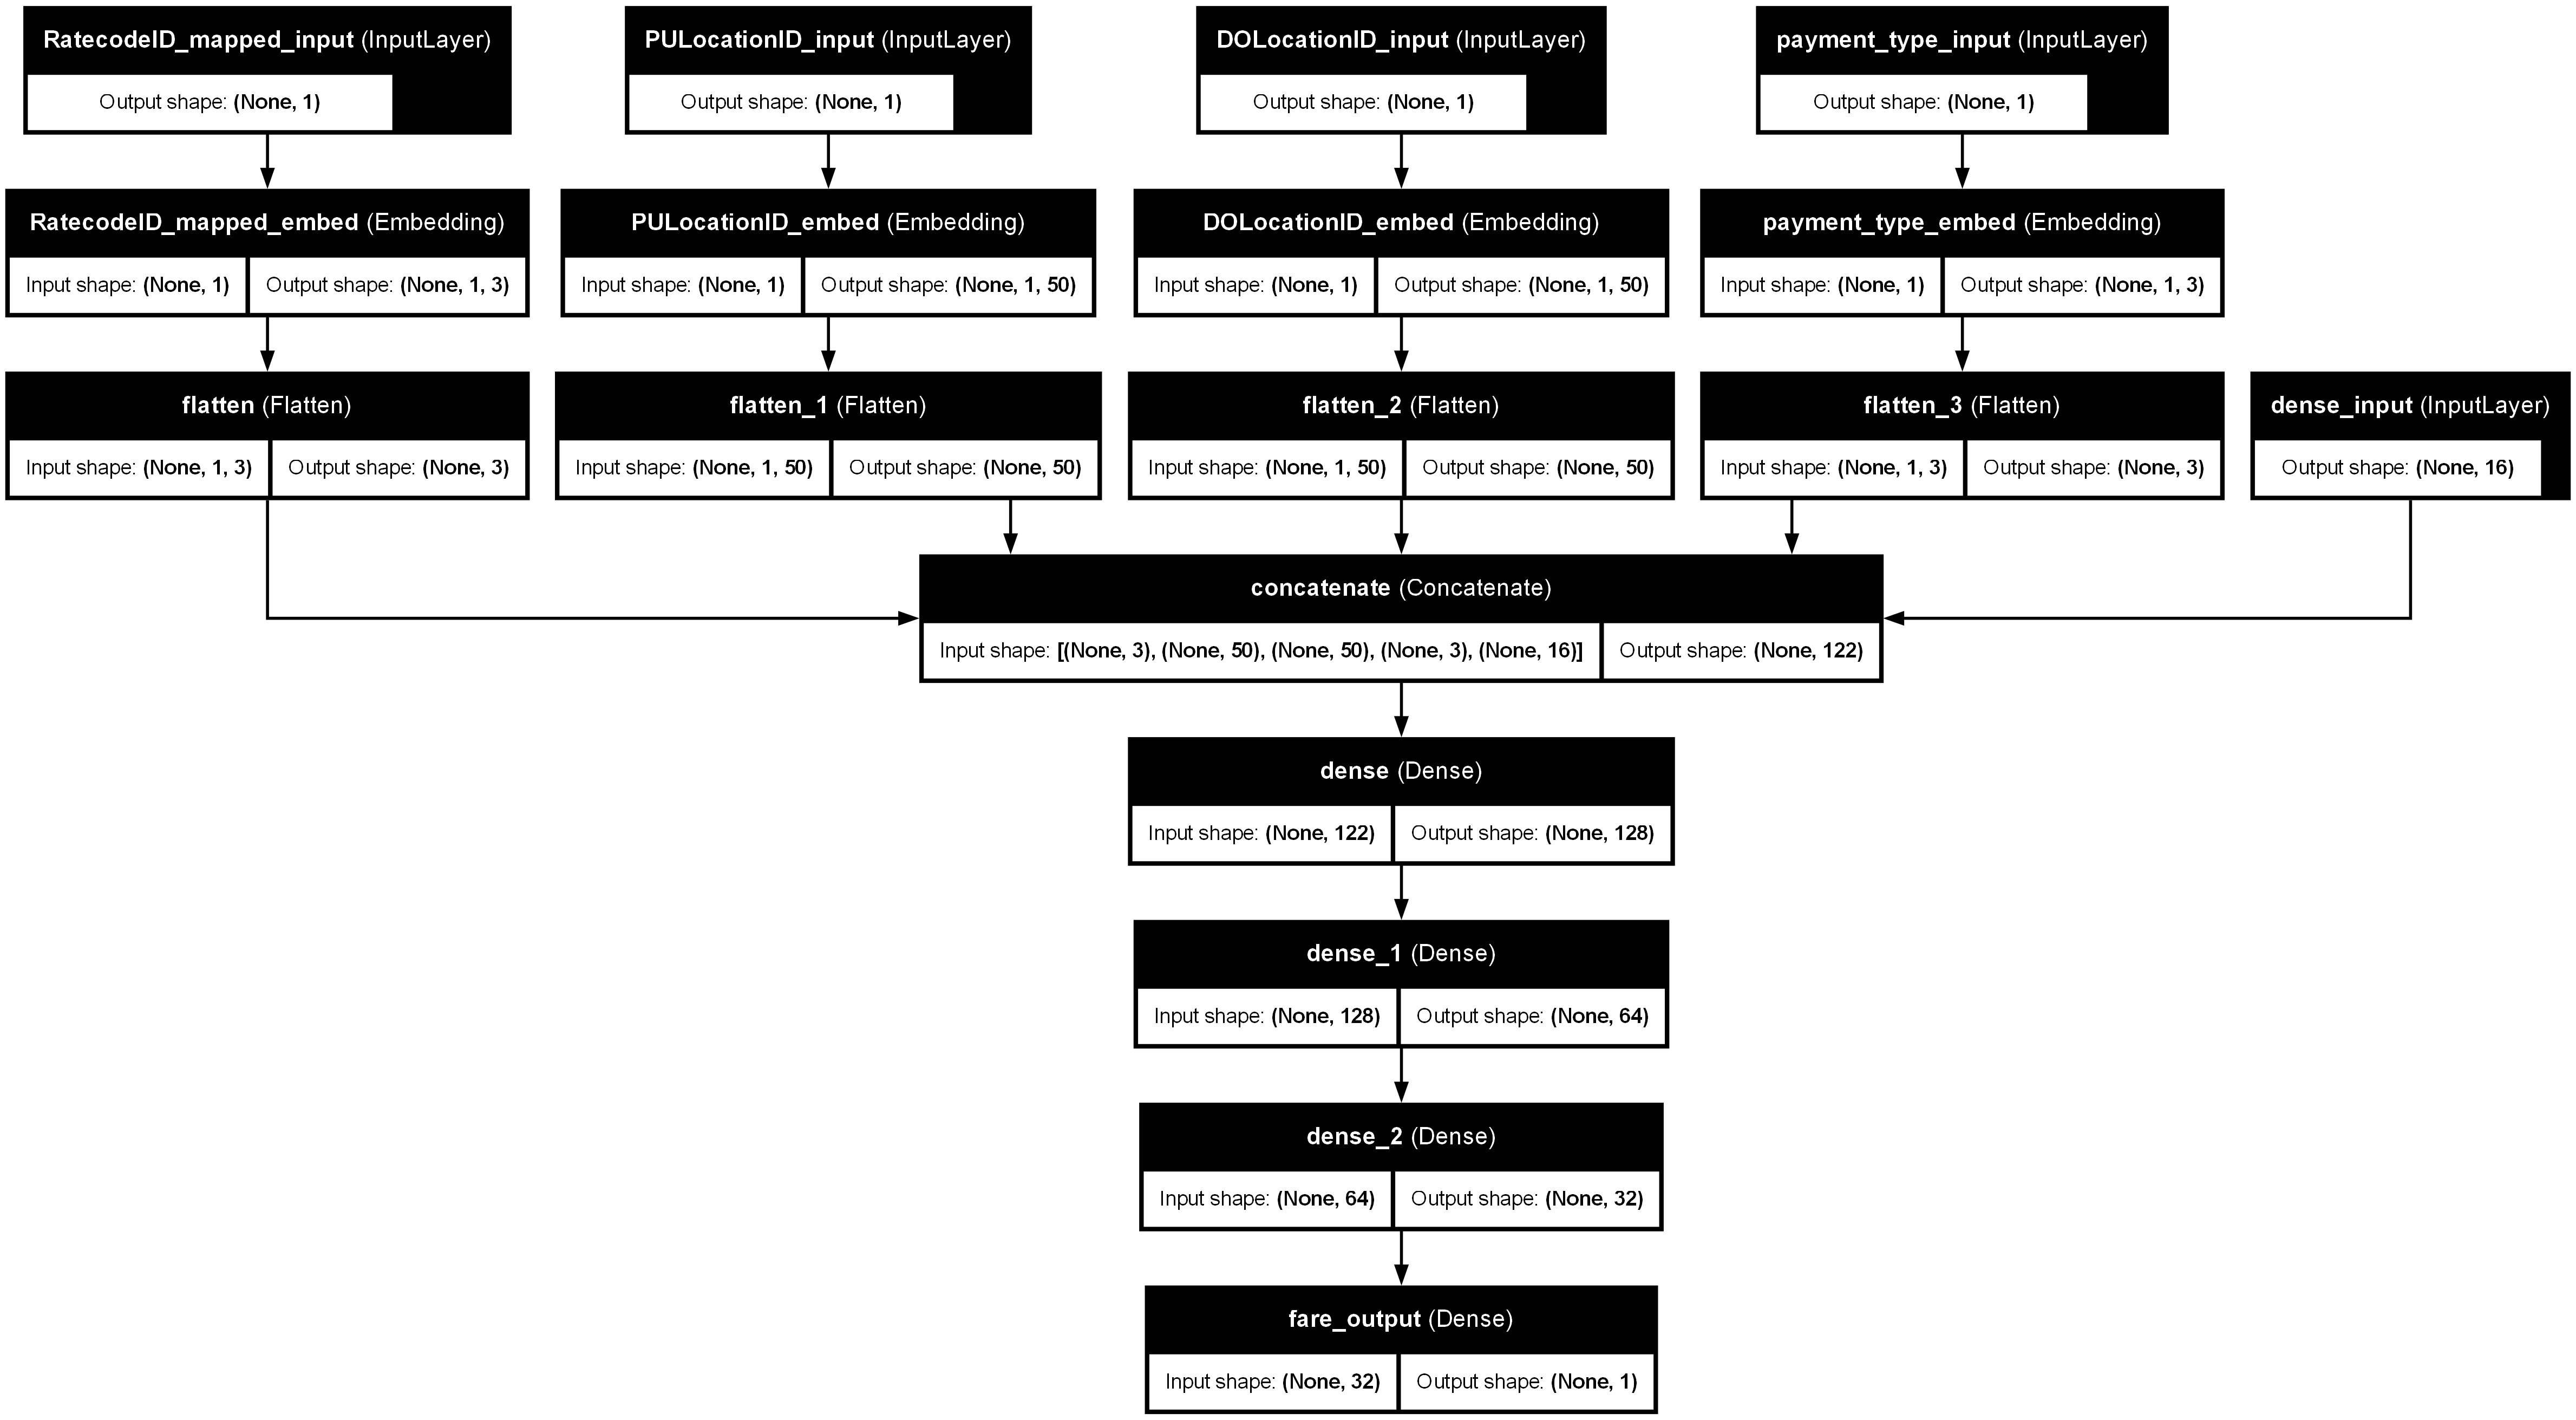

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model_v1, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')


### **Model Training with Early Stopping and Checkpointing**

This section trains `model_v1`and using the prepared training and validation datasets (`X_train_inputs`, `y_train_final`, `X_val_inputs`, `y_val_final`). To ensure efficient training and prevent overfitting, two key Keras callbacks are implemented:

1.  **Early Stopping:** Monitors the `val_loss` (validation loss) and halts training if it doesn't improve for a specified number of epochs (`patience=3`). This saves computational resources and helps find the optimal number of training epochs. Upon stopping, it restores the model weights from the epoch with the best validation loss.
2.  **Model Checkpointing:** Saves the model's weights (`.h5` format) to `best_model_v1.h5` and whenever a new best `val_loss` is achieved during training. This ensures that we always have access to the best performing model based on the validation set, even if training continues for more epochs or is stopped prematurely.

The model will be trained for a maximum of 30 epochs with a batch size of 256. Verbose output is enabled to monitor the training progress.

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_path_v1 = "best_model_v1.h5"

early_stop_v1 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint_v1 = ModelCheckpoint(filepath=checkpoint_path_v1, monitor='val_loss', save_best_only=True, verbose=1)

history_v1 = model_v1.fit(
    X_train_inputs, y_train_final,
    validation_data=(X_val_inputs, y_val_final),
    epochs=30,
    batch_size=256,
    callbacks=[early_stop_v1, checkpoint_v1],
    verbose=1
)


Epoch 1/30
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2404 - mae: 0.1783
Epoch 1: val_loss improved from inf to 0.01428, saving model to best_model_v1.h5


4712/4712 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.2403 - mae: 0.1783 - val_loss: 0.0143 - val_mae: 0.0739
Epoch 2/30
4704/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - mae: 0.0673
Epoch 2: val_loss improved from 0.01428 to 0.01413, saving model to best_model_v1.h5


4712/4712 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0135 - mae: 0.0673 - val_loss: 0.0141 - val_mae: 0.0737
Epoch 3/30
4696/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - mae: 0.0648
Epoch 3: val_loss improved from 0.01413 to 0.01284, saving model to best_model_v1.h5


4712/4712 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0129 - mae: 0.0648 - val_loss: 0.0128 - val_mae: 0.0628
Epoch 4/30
4708/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - mae: 0.0636
Epoch 4: val_loss improved from 0.01284 to 0.01256, saving model to best_model_v1.h5


4712/4712 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0128 - mae: 0.0636 - val_loss: 0.0126 - val_mae: 0.0606
Epoch 5/30
4709/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - mae: 0.0627
Epoch 5: val_loss did not improve from 0.01256
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.0124 - mae: 0.0627 - val_loss: 0.0127 - val_mae: 0.0600
Epoch 6/30
4711/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - mae: 0.0620
Epoch 6: val_loss did not improve from 0.01256
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0121 - mae: 0.0620 - val_loss: 0.0128 - val_mae: 0.0661
Epoch 7/30
4705/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - mae: 0.0613
Epoch 7: val_loss improved from 0.01256 to 0.01223, saving model to best_model_v1.h5


4712/4712 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 0.0119 - mae: 0.0613 - val_loss: 0.0122 - val_mae: 0.0611
Epoch 8/30
4704/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - mae: 0.0611
Epoch 8: val_loss did not improve from 0.01223
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0118 - mae: 0.0611 - val_loss: 0.0123 - val_mae: 0.0592
Epoch 9/30
4701/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - mae: 0.0610
Epoch 9: val_loss did not improve from 0.01223
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.0119 - mae: 0.0610 - val_loss: 0.0124 - val_mae: 0.0601
Epoch 10/30
4695/4712 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - mae: 0.0607
Epoch 10: val_loss did not improve from 0.01223
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0117 - mae: 0.0607 - val_loss: 0.0125 - val_mae: 0.0640
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


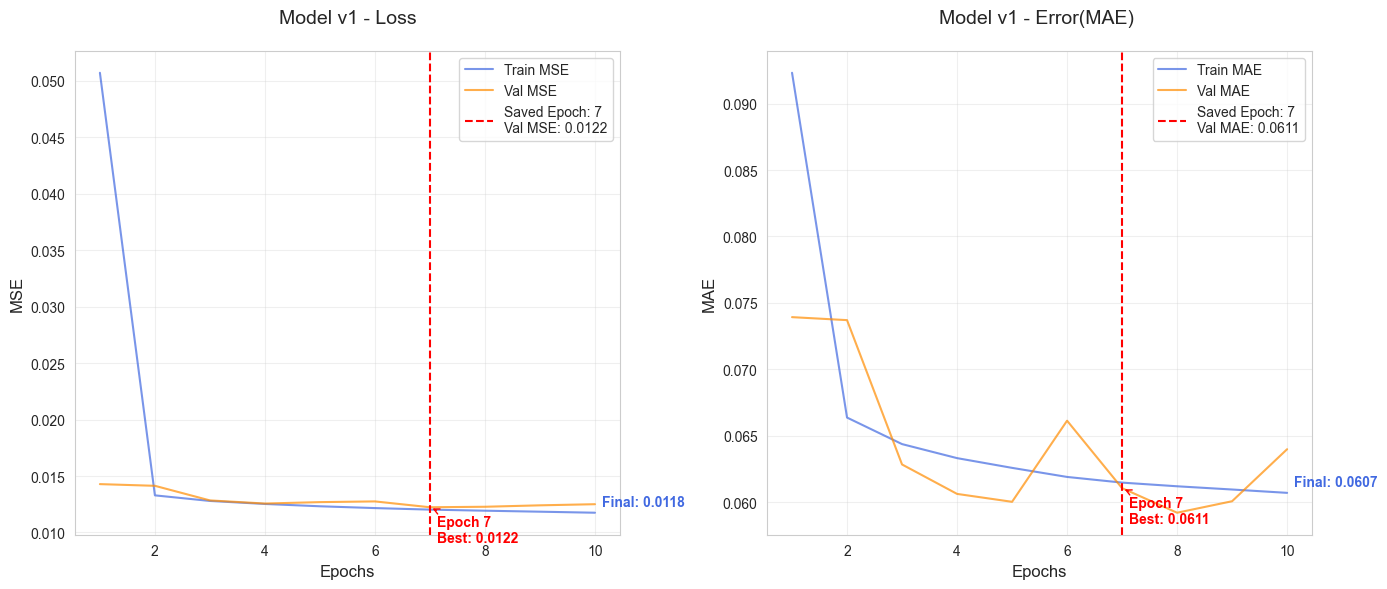

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))

# -----------------------
# Step 1: Define best epoch
# -----------------------
best_epoch_v1 = np.argmin(history_v1.history['val_loss'])  # 0-based
saved_epoch = best_epoch_v1 + 1                             # 1-based, like logs
best_mse = history_v1.history['val_loss'][best_epoch_v1]
best_mae = history_v1.history['val_mae'][best_epoch_v1]

# ---------------------------
# Step 2: Plot MSE
# ---------------------------
plt.subplot(1, 2, 1)
train_mse = history_v1.history['loss']
val_mse = history_v1.history['val_loss']

plt.plot(range(1, len(train_mse) + 1), train_mse, label='Train MSE', color='royalblue', alpha=0.7)
plt.plot(range(1, len(val_mse) + 1), val_mse, label='Val MSE', color='darkorange', alpha=0.7)

plt.axvline(x=saved_epoch, color='red', linestyle='--', 
            label=f'Saved Epoch: {saved_epoch}\nVal MSE: {best_mse:.4f}')

plt.annotate(f'Final: {train_mse[-1]:.4f}', 
             xy=(len(train_mse), train_mse[-1]),
             xytext=(5, 5), textcoords='offset points',
             color='royalblue', fontweight='bold')

plt.annotate(f'Epoch {saved_epoch}\nBest: {best_mse:.4f}', 
             xy=(saved_epoch, best_mse),
             xytext=(5, -25), textcoords='offset points',
             color='red', fontweight='bold',
             arrowprops=dict(arrowstyle="->", color='red'))

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Model v1 - Loss', fontsize=14, pad=20)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

# ---------------------------
# Step 3: Plot MAE
# ---------------------------
plt.subplot(1, 2, 2)
train_mae = history_v1.history['mae']
val_mae = history_v1.history['val_mae']

plt.plot(range(1, len(train_mae) + 1), train_mae, label='Train MAE', color='royalblue', alpha=0.7)
plt.plot(range(1, len(val_mae) + 1), val_mae, label='Val MAE', color='darkorange', alpha=0.7)

plt.axvline(x=saved_epoch, color='red', linestyle='--', 
            label=f'Saved Epoch: {saved_epoch}\nVal MAE: {best_mae:.4f}')

plt.annotate(f'Final: {train_mae[-1]:.4f}', 
             xy=(len(train_mae), train_mae[-1]),
             xytext=(5, 5), textcoords='offset points',
             color='royalblue', fontweight='bold')

plt.annotate(f'Epoch {saved_epoch}\nBest: {best_mae:.4f}', 
             xy=(saved_epoch, best_mae),
             xytext=(5, -25), textcoords='offset points',
             color='red', fontweight='bold',
             arrowprops=dict(arrowstyle="->", color='red'))

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Model v1 - Error(MAE) ', fontsize=14, pad=20)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [40]:
# Reporting the saved/best epoch and its validation metrics
print("✅ Model Saved at Best Epoch")
print(f"• Epoch       : {saved_epoch}")
print(f"• Val Loss (MSE): {best_mse:.6f}")
print(f"• Val MAE       : {best_mae:.6f}")


✅ Model Saved at Best Epoch
• Epoch       : 7
• Val Loss (MSE): 0.012235
• Val MAE       : 0.061051


In [114]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# === Step 1: Evaluate model on test set (returns loss and MAE in log1p scale) ===
test_loss, test_mae = model_v1.evaluate(X_test_inputs, y_test_final, verbose=1)

# === Step 2: Inverse-transform predictions and targets to dollar space ===
y_pred_dollars = np.expm1(model_v1.predict(X_test_inputs).reshape(-1))
y_true_dollars = np.expm1(y_test_final)

# === Step 3: Compute true MAE in original dollar scale ===
true_mae_dollars = mean_absolute_error(y_true_dollars, y_pred_dollars)

# === Step 4: Validation MAE (log1p) from best epoch ===
val_mae = history_v1.history['val_mae'][best_epoch_v1]
val_mae_dollars = np.expm1(val_mae)

# === Step 5: Compute generalization gap (between val and test) ===
gap_pct = (test_mae - val_mae) / val_mae * 100

# === Step 6: Reporting block ===
print("=" * 65)
print("🧪 Test Set Evaluation Summary")
print("-" * 65)
print(f"Test MSE (log1p scale):          {test_loss:.6f}")
print(f"Test MAE (log1p scale):          {test_mae:.6f}")
print(f"Estimated MAE via expm1():       ${np.expm1(test_mae):.2f} (approx)")
print(f"✅ True MAE in dollar scale:      ${true_mae_dollars:.2f}")
print("-" * 65)
print(f"Saved Epoch:                     {saved_epoch}")
print(f"Validation MAE (log1p scale):    {val_mae:.6f}")
print(f"Validation MAE (USD):            ${val_mae_dollars:.2f}")
print(f"Validation vs Test Gap:          {gap_pct:.1f}%")
print("=" * 65)


12564/12564 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0121 - mae: 0.0611
12564/12564 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
🧪 Test Set Evaluation Summary
-----------------------------------------------------------------
Test MSE (log1p scale):          0.012086
Test MAE (log1p scale):          0.060968
Estimated MAE via expm1():       $0.06 (approx)
✅ True MAE in dollar scale:      $1.72
-----------------------------------------------------------------
Saved Epoch:                     7
Validation MAE (log1p scale):    0.061051
Validation MAE (USD):            $0.06
Validation vs Test Gap:          -0.1%


In [113]:
# === Evaluate model on test set ===
test_loss, test_mae = model_v1.evaluate(X_test_inputs, y_test_final, verbose=1)

# === Convert log-scale MAE to approximate dollar estimate ===
test_mae_dollars = np.expm1(test_mae)  # Rough approximation of mean error in real dollar space

# === Use saved/best epoch's val_mae instead of np.min ===
val_mae = history_v1.history['val_mae'][best_epoch_v1]
val_mae_dollars = np.expm1(val_mae)

# === Compute generalization gap (% difference between validation and test MAE) ===
gap_pct = (test_mae - val_mae) / val_mae * 100

# === Print metrics summary ===
print("="*60)
print(f"Test MSE (log1p scale):     {test_loss:.6f}")
print(f"Test MAE (log1p scale):     {test_mae:.6f}")
print(f"Approx. Test MAE (USD):     ${test_mae_dollars:.2f}")
print("-" * 60)
print(f"Saved Epoch:                {saved_epoch}")
print(f"Val MAE (log1p scale):      {val_mae:.6f}")
print(f"Approx. Val MAE (USD):      ${val_mae_dollars:.2f}")
print(f"Validation vs Test Gap:     {gap_pct:.1f}%")
print("="*60)


12564/12564 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0121 - mae: 0.0611
Test MSE (log1p scale):     0.012086
Test MAE (log1p scale):     0.060968
Approx. Test MAE (USD):     $0.06
------------------------------------------------------------
Saved Epoch:                7
Val MAE (log1p scale):      0.061051
Approx. Val MAE (USD):      $0.06
Validation vs Test Gap:     -0.1%


**gap_pct** shows how much worse the model performs on new, unseen data (test set) compared to the validation set it saw during training. A small gap means your model generalizes well. A large gap suggests overfitting or poor data representation."



# **Predictions**

12564/12564 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
📊 Real MAE in Dollars: $1.72


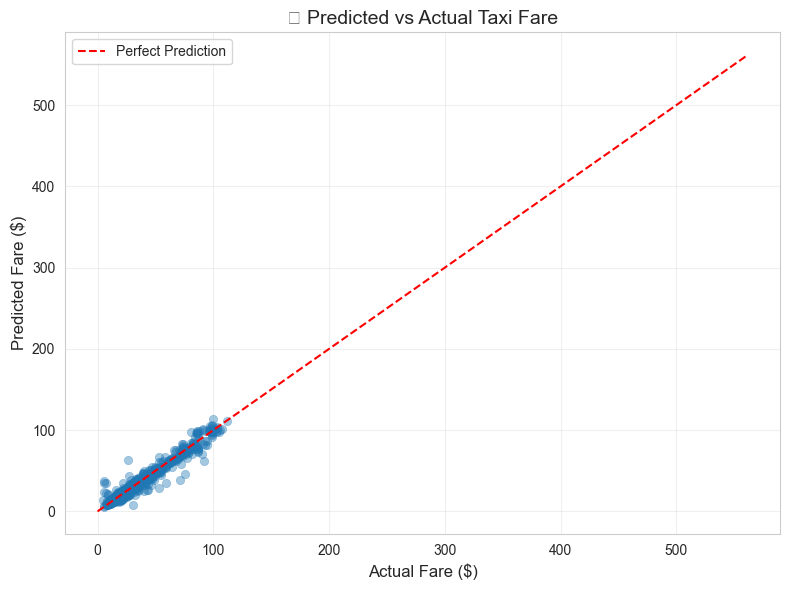

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1. Make predictions using the model
preds = model_v1.predict(X_test_inputs)

# 2. Flatten predictions to 1D array
preds_flat = preds.reshape(-1)

# 3. Reverse log1p transformation on predictions
preds_inv = np.expm1(preds_flat)

# 4. Reverse log1p transformation on true values
y_true_inv = np.expm1(y_test_final)

# 5. Create a DataFrame to compare
results_df = pd.DataFrame({
    'y_true': y_true_inv,
    'y_pred': preds_inv
})

# 6. Compute Real MAE in dollars
real_mae = mean_absolute_error(results_df['y_true'], results_df['y_pred'])
print(f"📊 Real MAE in Dollars: ${real_mae:.2f}")

# 7. Scatterplot: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x='y_true', y='y_pred', data=results_df.sample(2000), alpha=0.4, edgecolor=None)

# Diagonal reference line
plt.plot([0, results_df['y_true'].max()], [0, results_df['y_true'].max()],
         '--', color='red', label='Perfect Prediction')

plt.xlabel("Actual Fare ($)", fontsize=12)
plt.ylabel("Predicted Fare ($)", fontsize=12)
plt.title("📈 Predicted vs Actual Taxi Fare", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


 Percentage Errors in Original Fare Scale

In [45]:
# Calculate MAE and RMSE in original dollar scale
mae_dollars = np.mean(np.abs(results_df['y_true'] - results_df['y_pred']))
rmse_dollars = np.sqrt(np.mean((results_df['y_true'] - results_df['y_pred'])**2))

# Calculate mean fare to contextualize errors
mean_fare = results_df['y_true'].mean()
mae_percentage = (mae_dollars / mean_fare) * 100

print(f"MAE (dollars): ${mae_dollars:.2f}")
print(f"RMSE (dollars): ${rmse_dollars:.2f}")
print(f"MAE as % of mean fare: {mae_percentage:.2f}%")

MAE (dollars): $1.72
RMSE (dollars): $3.39
MAE as % of mean fare: 6.41%


The model achieves a mean absolute error (MAE) of $1.72, which is just 6.41% of the average fare. The RMSE is $3.39, indicating that large errors are relatively rare.



In [61]:
print(f"y_test_final: {len(y_test_final)}")
print(f"preds_flat:   {len(preds_flat)}")
print(f"results_df:   {len(results_df)}")
print(f"X_test:       {len(X_test)}")


y_test_final: 402031
preds_flat:   402031
results_df:   402031
X_test:       402031


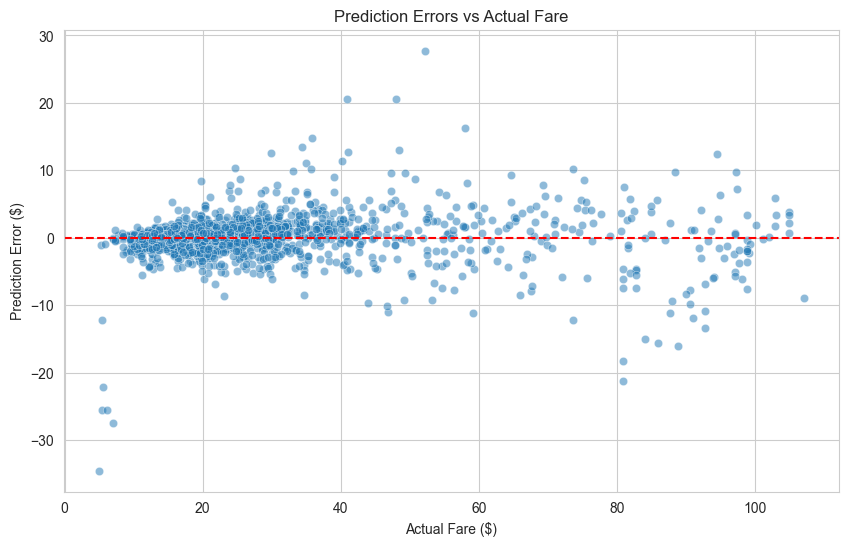

In [62]:
# Add error column to results DataFrame
results_df['error'] = results_df['y_true'] - results_df['y_pred']
# Plot error distribution vs actual fare
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='y_true', 
    y='error', 
    data=results_df.sample(2000, random_state=42),  # Subsample for clarity
    alpha=0.5
)
plt.axhline(0, color='red', linestyle='--')  # Zero error reference line
plt.xlabel("Actual Fare ($)")
plt.ylabel("Prediction Error ($)")
plt.title("Prediction Errors vs Actual Fare")
plt.show()

In [98]:
# Step 1: Copy original input features from X_test before preprocessing
X_test_original = X_test.copy().reset_index(drop=True)

# Step 2: Reset the index of the results_df to align with inputs
results_df = results_df.reset_index(drop=True)

# Step 3: Combine original features with predictions for analysis
full_results = pd.concat([X_test_original, results_df], axis=1)

# Undo log1p transformation
full_results['duration_inMin'] = np.expm1(full_results['duration_inMin'])
full_results['trip_distance'] = np.expm1(full_results['trip_distance'])


# Step 4: Inspect
full_results.head()


,VendorID,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,duration_inMin,average_speed,pickup_hour,pickup_dayofweek,pickup_month,dropoff_hour,is_weekend,median_speed,is_congestion,source,RatecodeID_mapped,y_true,y_pred,error
0,1,1.0,2.14,239,75,0.0,13.433333,2.356913,0,6,3,0,True,2.623906,False,yellow,6,19.29,19.643726,-0.353726
1,1,1.0,1.40,125,90,0.0,11.900000,2.086768,21,1,9,22,False,2.389764,False,yellow,6,17.22,17.248638,-0.028638
2,2,1.0,1.38,263,238,1.0,8.366667,2.388434,15,6,3,15,True,2.247996,False,yellow,0,17.20,16.482040,0.717960
3,2,1.0,0.36,263,236,2.0,4.116667,1.832096,13,3,10,13,False,2.308146,False,yellow,0,9.80,9.541064,0.258936
4,2,2.0,0.91,161,237,1.0,4.650000,2.544899,21,4,12,22,False,2.334394,False,yellow,0,15.86,13.931012,1.928988


In [48]:
full_results.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'PULocationID',
       'DOLocationID', 'payment_type', 'duration_inMin', 'average_speed',
       'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'dropoff_hour',
       'is_weekend', 'median_speed', 'is_congestion', 'source',
       'RatecodeID_mapped', 'y_true', 'y_pred', 'error'],
      dtype='object')

In [99]:
# 1. Create a copy for error bin analysis without modifying the original full_results
error_df = full_results[full_results['y_true'] > 0].copy()

# 2. Calculate percentage error (signed)
error_df['percentage_error'] = ((error_df['y_true'] - error_df['y_pred']) / error_df['y_true']) * 100

# 3. Calculate absolute percentage error
error_df['abs_percentage_error'] = error_df['percentage_error'].abs()

# 4. Define error bins (customize as needed)
bins = [0, 5, 10, 20, 30, 50, 100, np.inf]
labels = ['0-5%', '5-10%', '10-20%', '20-30%', '30-50%', '50-100%', '100%+']
error_df['error_bin'] = pd.cut(error_df['abs_percentage_error'], bins=bins, labels=labels)

# 5. Count how many predictions fall into each error group
error_distribution = error_df['error_bin'].value_counts(sort=False).reset_index()
error_distribution.columns = ['Error Range (%)', 'Count']

# 6. Calculate percentage of total
total = len(error_df)
error_distribution['Percent of Total'] = (error_distribution['Count'] / total) * 100

# 7. Show result
print(error_distribution)


  Error Range (%)   Count  Percent of Total
0            0-5%  232379         57.801408
1           5-10%  102151         25.408800
2          10-20%   51290         12.757754
3          20-30%   10322          2.567470
4          30-50%    4036          1.003905
5         50-100%     831          0.206701
6           100%+    1021          0.253961


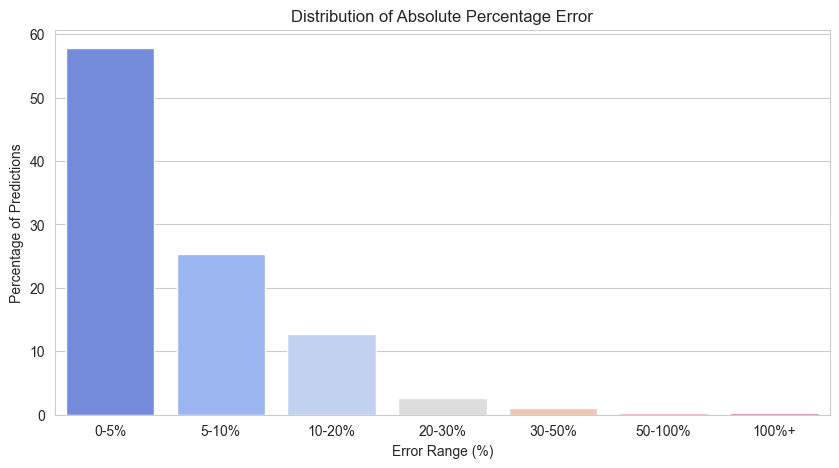

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x='Error Range (%)', y='Percent of Total', data=error_distribution, palette='coolwarm')
plt.title("Distribution of Absolute Percentage Error")
plt.ylabel("Percentage of Predictions")
plt.xlabel("Error Range (%)")
plt.grid(True, axis='y')
plt.show()


In [103]:
# Percentage of predictions within 0–10% absolute percentage error
within_10_percent = (error_df['abs_percentage_error'] <= 10).mean() * 100
print(f"{within_10_percent:.2f}% of predictions have less than or equal to 10% error.")


83.21% of predictions have less than or equal to 10% error.


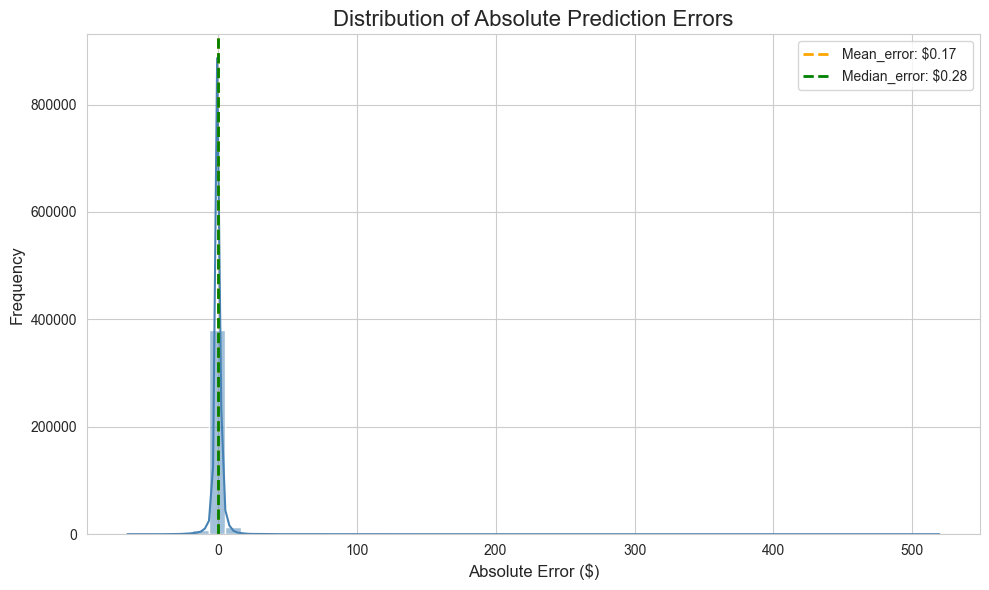

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Histogram + KDE plot of absolute error
sns.histplot(full_results['error'], bins=50, kde=True, color='steelblue')

# Add mean and median lines
mean_error = full_results['error'].mean()
median_error = full_results['error'].median()

plt.axvline(mean_error, color='orange', linestyle='--', linewidth=2, label=f'Mean_error: ${mean_error:.2f}')
plt.axvline(median_error, color='green', linestyle='--', linewidth=2, label=f'Median_error: ${median_error:.2f}')

# Titles and labels
plt.title("Distribution of Absolute Prediction Errors", fontsize=16)
plt.xlabel("Absolute Error ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()




In [54]:
full_results.describe()

,VendorID,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,duration_inMin,average_speed,pickup_hour,pickup_dayofweek,pickup_month,dropoff_hour,median_speed,RatecodeID_mapped,y_true,y_pred,error,percentage_error,abs_percentage_error
count,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000,402030.000000
mean,1.765846,1.306674,1.164019,163.772930,163.442738,1.101649,2.621832,2.344644,14.298965,3.025737,6.635393,14.355140,2.343042,0.668127,26.874992,26.709150,0.165841,-0.435494,6.818588
std,0.424232,0.770295,0.625966,64.915519,69.372965,0.629863,0.648854,0.464893,5.833537,1.937262,3.440053,5.939139,0.285287,1.845166,18.432198,18.471960,3.382579,19.901244,18.701762
min,1.000000,1.000000,0.009950,1.000000,1.000000,0.000000,0.095310,0.009677,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.500000,4.249645,-65.104998,-1324.685499,0.000054
25%,2.000000,1.000000,0.717840,132.000000,113.000000,1.000000,2.182299,2.057440,11.000000,1.000000,4.000000,11.000000,2.149833,0.000000,15.960000,15.847384,-0.679904,-3.182177,1.975015
50%,2.000000,1.000000,1.015231,161.000000,162.000000,1.000000,2.627081,2.323787,15.000000,3.000000,7.000000,15.000000,2.290466,0.000000,21.000000,20.752973,0.284038,1.429563,4.154772
75%,2.000000,1.000000,1.439835,234.000000,234.000000,1.000000,3.066501,2.608660,19.000000,5.000000,10.000000,19.000000,2.437061,0.000000,29.750000,29.190201,1.032864,4.574949,7.719252
max,6.000000,6.000000,3.047376,265.000000,265.000000,5.000000,4.277129,4.257030,23.000000,6.000000,12.000000,23.000000,5.181709,6.000000,561.350000,148.294998,519.480226,92.541236,1324.685499


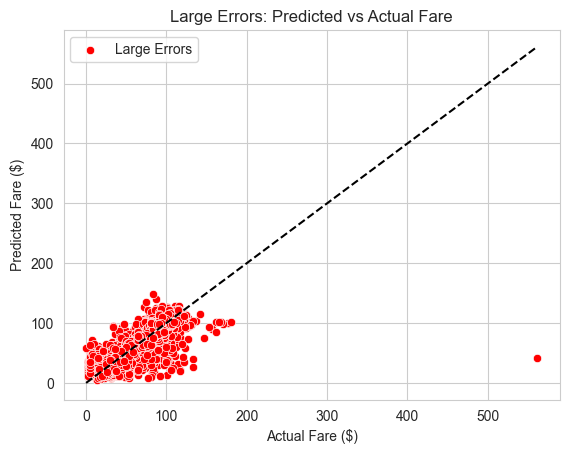

In [104]:
# Identify worst predictions (top 5% absolute errors)
threshold = np.percentile(np.abs(full_results['error']), 95)
large_errors = full_results[np.abs(full_results['error']) >= threshold]

# Plot actual vs predicted for large errors
sns.scatterplot(
    x='y_true', 
    y='y_pred', 
    data=large_errors, 
    color='red',
    label='Large Errors'
)
plt.plot([0, large_errors['y_true'].max()], [0, large_errors['y_true'].max()], '--', color='black')
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.title("Large Errors: Predicted vs Actual Fare")
plt.legend()
plt.show()

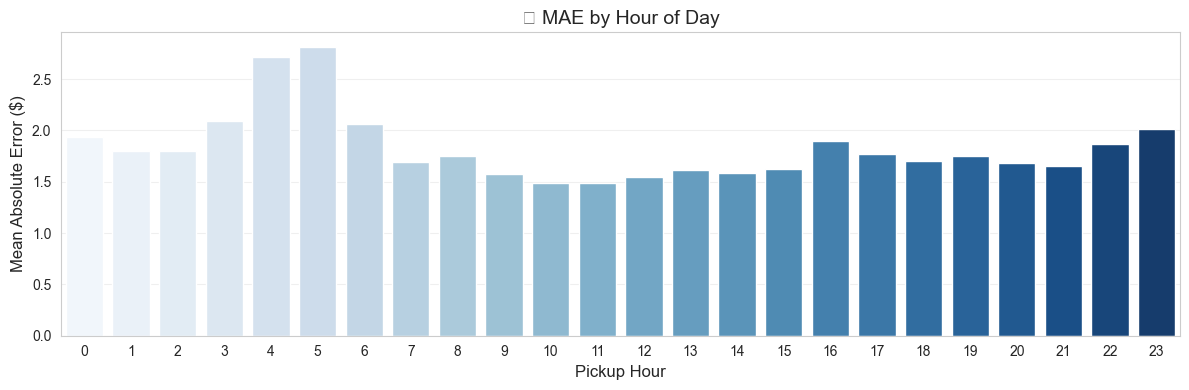

In [86]:
# Step 5: Calculate MAE grouped by pickup hour
hourly_mae = full_results.groupby('pickup_hour').apply(
    lambda g: mean_absolute_error(g['y_true'], g['y_pred'])
)

# Step 6: Plot
plt.figure(figsize=(12, 4))
sns.barplot(x=hourly_mae.index, y=hourly_mae.values, palette="Blues")

plt.xlabel("Pickup Hour", fontsize=12)
plt.ylabel("Mean Absolute Error ($)", fontsize=12)
plt.title("🚕 MAE by Hour of Day", fontsize=14)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


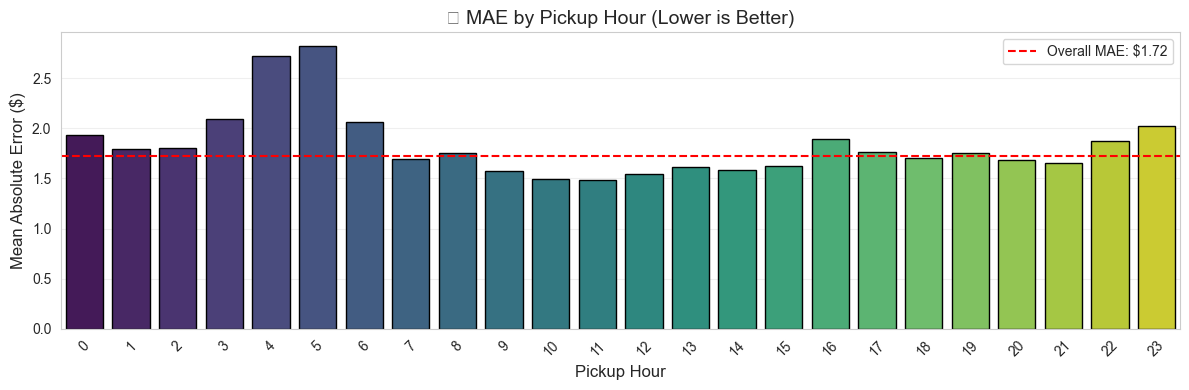

In [105]:
# ✅ Step 1: Make sure 'pickup_hour' exists
assert 'pickup_hour' in X_test.columns, "❌ 'pickup_hour' not found in X_test"

# ✅ Step 2: Add pickup_hour safely (aligning index)
full_results['pickup_hour'] = X_test['pickup_hour'].reset_index(drop=True)

# ✅ Step 3: Calculate MAE and standard deviation per hour
# ✅ Step 3: Calculate MAE and std per hour
hourly_stats = full_results.groupby('pickup_hour')[['y_pred', 'y_true']].apply(
    lambda df: pd.Series({
        'mae': mean_absolute_error(df['y_true'], df['y_pred']),
        'std': np.std(np.abs(df['y_pred'] - df['y_true']))
    })
).reset_index()

# ✅ Step 4: Plot MAE per hour with a reference line for overall MAE
overall_mae = mean_absolute_error(full_results['y_true'], full_results['y_pred'])

plt.figure(figsize=(12, 4))
sns.barplot(x='pickup_hour', y='mae', data=hourly_stats,
            palette='viridis', edgecolor='black')

# Reference line for overall MAE
plt.axhline(overall_mae, color='red', linestyle='--', label=f'Overall MAE: ${overall_mae:.2f}')

# Labels and title
plt.xlabel("Pickup Hour", fontsize=12)
plt.ylabel("Mean Absolute Error ($)", fontsize=12)
plt.title("🕐 MAE by Pickup Hour (Lower is Better)", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


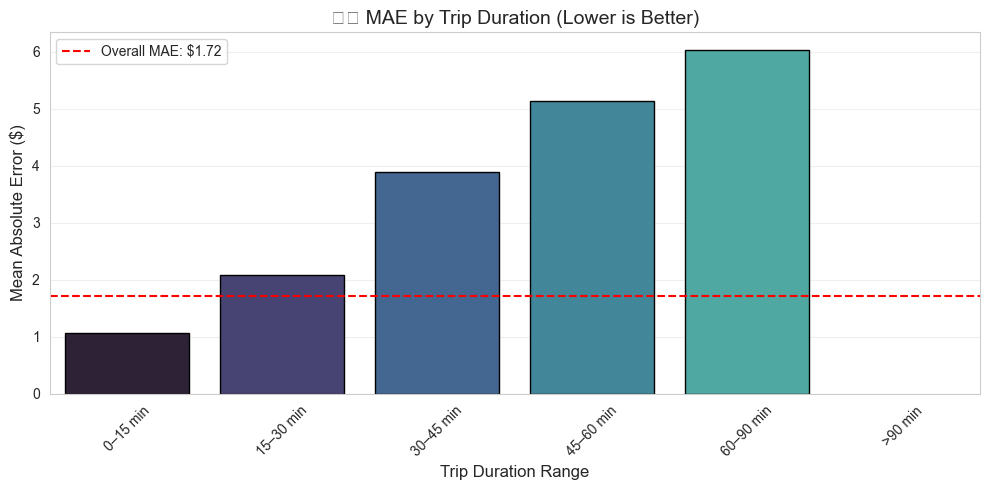

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# ✅ Step 1: Create duration bins
duration_bins = [0, 15, 30, 45, 60, 90, np.inf]
duration_labels = ['0–15 min', '15–30 min', '30–45 min', '45–60 min', '60–90 min', '>90 min']
full_results['duration_bin'] = pd.cut(full_results['duration_inMin'], bins=duration_bins, labels=duration_labels)

# ✅ Step 2: Drop rows with missing or NaN duration_bin (empty bin fallback)
full_results_duration = full_results.dropna(subset=['duration_bin'])

# ✅ Step 3: Group and compute metrics
duration_stats = (
    full_results_duration.groupby('duration_bin')[['y_true', 'y_pred']]
    .apply(lambda df: pd.Series({
        'mae': mean_absolute_error(df['y_true'], df['y_pred']) if len(df) > 0 else np.nan,
        'std': np.std(np.abs(df['y_pred'] - df['y_true'])) if len(df) > 0 else np.nan
    }))
    .reset_index()
)

# ✅ Step 4: Calculate overall MAE
overall_mae = mean_absolute_error(full_results['y_true'], full_results['y_pred'])

# ✅ Step 5: Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='duration_bin', y='mae', data=duration_stats,
            palette='mako', edgecolor='black')

# Add reference line
plt.axhline(overall_mae, color='red', linestyle='--', label=f'Overall MAE: ${overall_mae:.2f}')

# Labels and formatting
plt.xlabel("Trip Duration Range", fontsize=12)
plt.ylabel("Mean Absolute Error ($)", fontsize=12)
plt.title("⏱️ MAE by Trip Duration (Lower is Better)", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


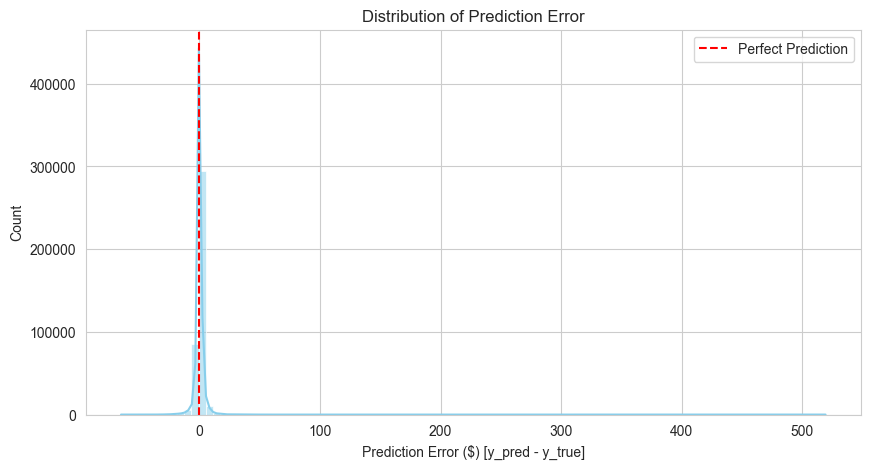

In [67]:
# ✅ Step 1: Visualize the prediction error distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(full_results['error'], bins=100, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Distribution of Prediction Error')
plt.xlabel('Prediction Error ($) [y_pred - y_true]')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()




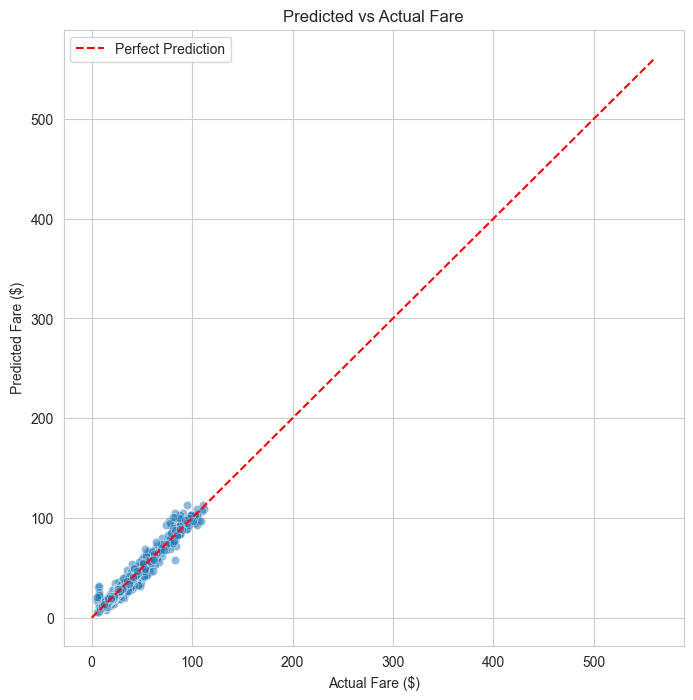

In [68]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='y_true', y='y_pred', data=full_results.sample(3000), alpha=0.5)
plt.plot([0, full_results['y_true'].max()], [0, full_results['y_true'].max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Fare ($)')
plt.ylabel('Predicted Fare ($)')
plt.title('Predicted vs Actual Fare')
plt.legend()
plt.grid(True)
plt.show()


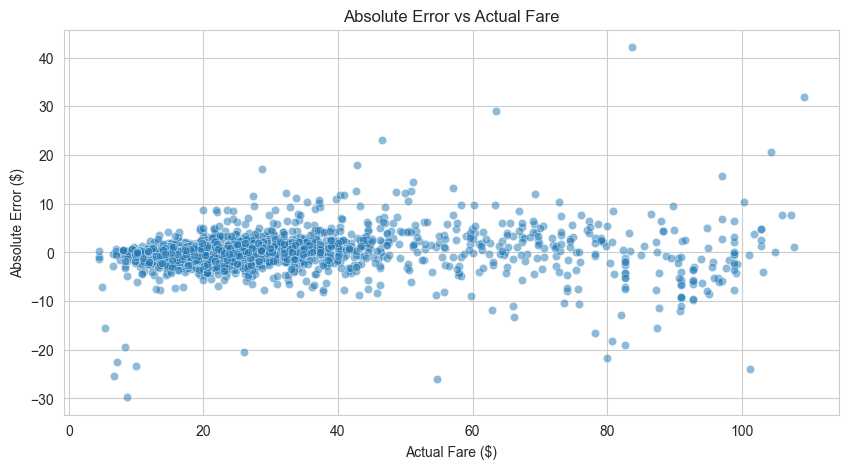

In [70]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=full_results.sample(3000), x='y_true', y='error', alpha=0.5)
plt.title('Absolute Error vs Actual Fare')
plt.xlabel('Actual Fare ($)')
plt.ylabel('Absolute Error ($)')
plt.grid(True)
plt.show()


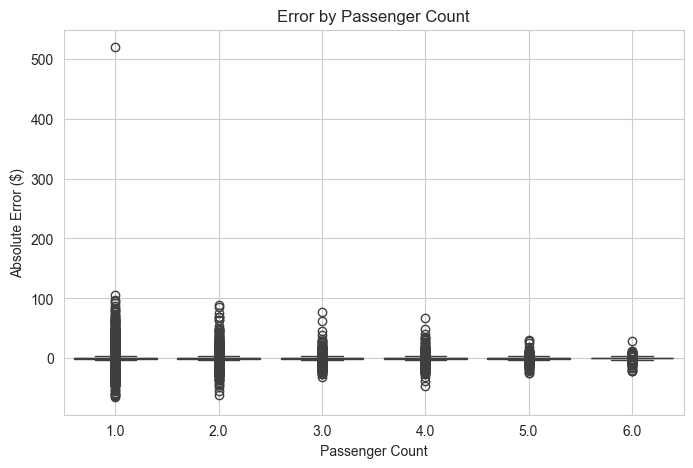

In [72]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='passenger_count', y='error', data=full_results)
plt.title('Error by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Absolute Error ($)')
plt.grid(True)
plt.show()


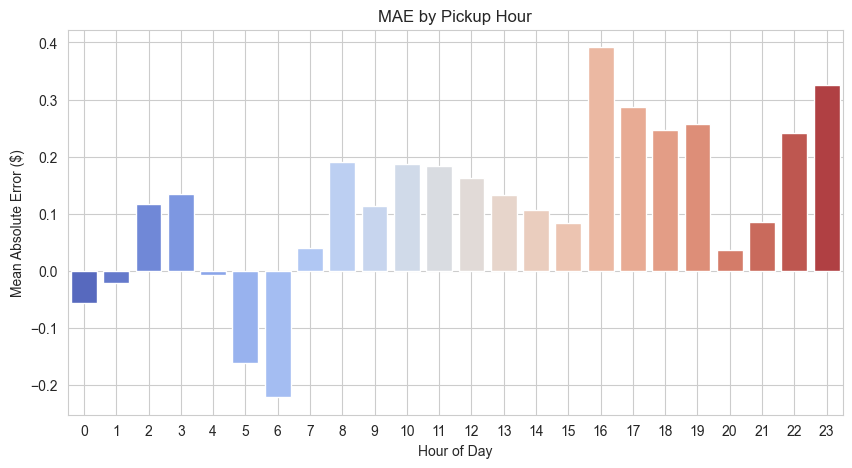

In [88]:
hourly_mae = full_results.groupby('pickup_hour')['error'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='pickup_hour', y='error', data=hourly_mae, palette='coolwarm')
plt.title('MAE by Pickup Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Absolute Error ($)')
plt.grid(True)
plt.show()


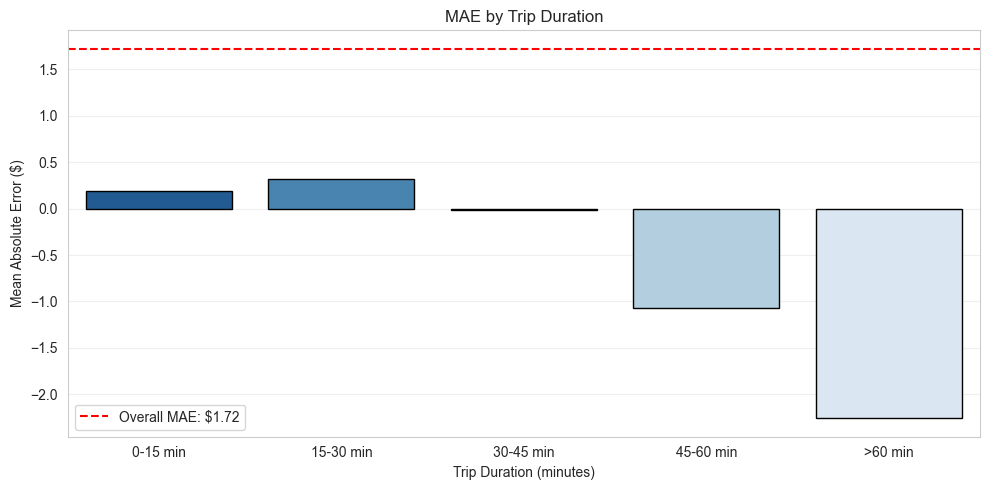

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Bin duration into categories
duration_bins = [0, 15, 30, 45, 60, np.inf]
duration_labels = ['0-15 min', '15-30 min', '30-45 min', '45-60 min', '>60 min']
full_results['duration_bin'] = pd.cut(full_results['duration_inMin'], bins=duration_bins, labels=duration_labels)

# 2. Group and calculate MAE
duration_mae_stats = full_results.groupby('duration_bin')['error'].agg(['mean', 'count'])

# 3. Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=duration_mae_stats.index, y=duration_mae_stats['mean'], palette='Blues_r', edgecolor='black')

plt.axhline(full_results['error'].abs().mean(), color='red', linestyle='--', label=f'Overall MAE: ${full_results["error"].abs().mean():.2f}')
plt.ylabel("Mean Absolute Error ($)")
plt.xlabel("Trip Duration (minutes)")
plt.title("MAE by Trip Duration")
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [78]:
# Check how many trips fall into each duration bin
duration_counts = full_results['duration_bin'].value_counts(sort=False)
print(duration_counts)


duration_bin
0-15 min     402030
15-30 min         0
30-45 min         0
45-60 min         0
>60 min           0
Name: count, dtype: int64


In [111]:
# Check typical values
print(full_results['duration_inMin'].describe())

count    402031.000000
mean         15.893965
std          11.460679
min           0.100000
25%           7.866667
50%          12.833333
75%          20.466667
max          71.033333
Name: duration_inMin, dtype: float64


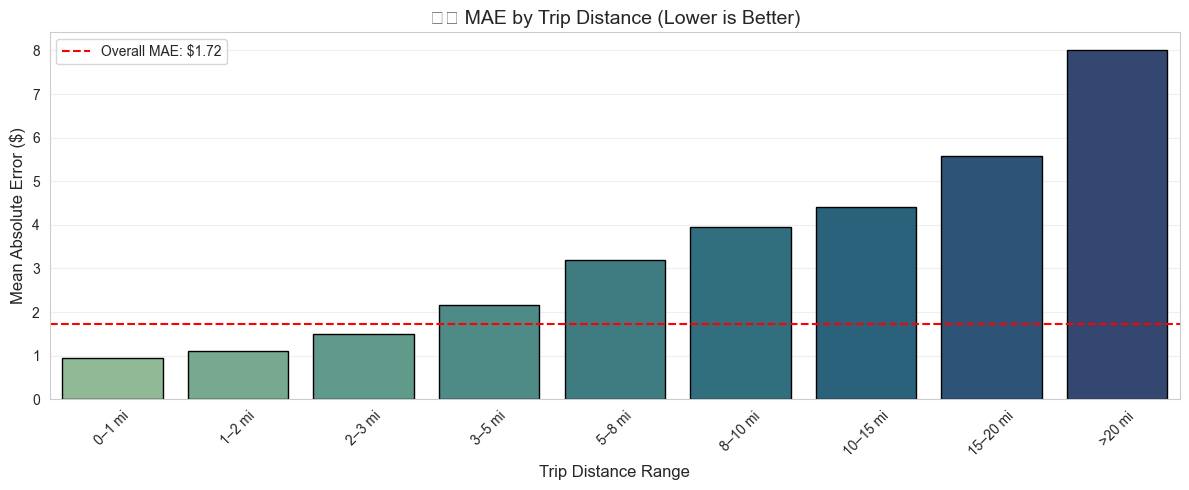

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# ✅ Step 1: Create trip distance bins (customize as needed)
distance_bins = [0, 1, 2, 3, 5, 8, 10, 15, 20, np.inf]
distance_labels = [
    '0–1 mi', '1–2 mi', '2–3 mi', '3–5 mi', '5–8 mi', 
    '8–10 mi', '10–15 mi', '15–20 mi', '>20 mi'
]

full_results['distance_bin'] = pd.cut(full_results['trip_distance'], bins=distance_bins, labels=distance_labels)

# ✅ Step 2: Drop rows with missing or NaN distance_bin
full_results_distance = full_results.dropna(subset=['distance_bin'])

# ✅ Step 3: Group by distance_bin and compute MAE + Std
distance_stats = full_results_distance.groupby('distance_bin')[['y_true', 'y_pred']].apply(
    lambda df: pd.Series({
        'mae': mean_absolute_error(df['y_true'], df['y_pred']),
        'std': np.std(np.abs(df['y_pred'] - df['y_true']))
    })
).reset_index()

# ✅ Step 4: Overall MAE line
overall_mae = mean_absolute_error(full_results['y_true'], full_results['y_pred'])

# ✅ Step 5: Plot
plt.figure(figsize=(12, 5))
sns.barplot(x='distance_bin', y='mae', data=distance_stats,
            palette='crest', edgecolor='black')

plt.axhline(overall_mae, color='red', linestyle='--', label=f'Overall MAE: ${overall_mae:.2f}')
plt.xlabel("Trip Distance Range", fontsize=12)
plt.ylabel("Mean Absolute Error ($)", fontsize=12)
plt.title("🛣️ MAE by Trip Distance (Lower is Better)", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


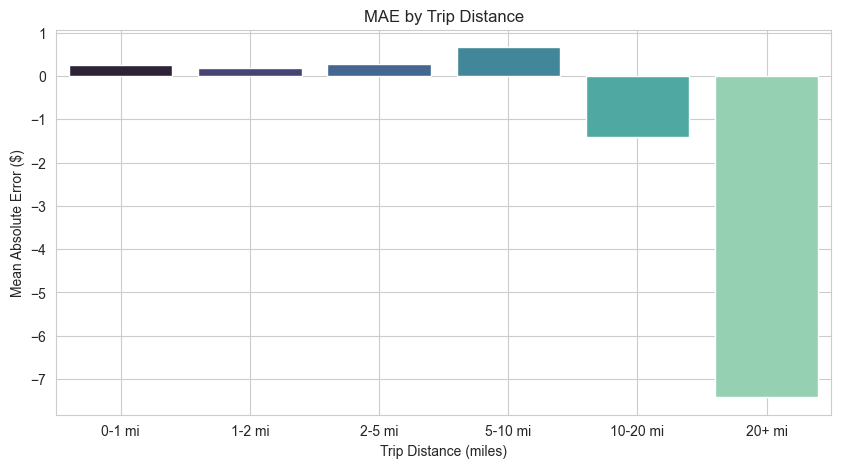

In [90]:
# Bin trip distances
bins = [0, 1, 2, 5, 10, 20, np.inf]
labels = ['0-1 mi', '1-2 mi', '2-5 mi', '5-10 mi', '10-20 mi', '20+ mi']
full_results['distance_bin'] = pd.cut(full_results['trip_distance'], bins=bins, labels=labels)

# Calculate MAE per bin
dist_mae = full_results.groupby('distance_bin')['error'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='distance_bin', y='error', data=dist_mae, palette='mako')
plt.title('MAE by Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Mean Absolute Error ($)')
plt.grid(True)
plt.show()


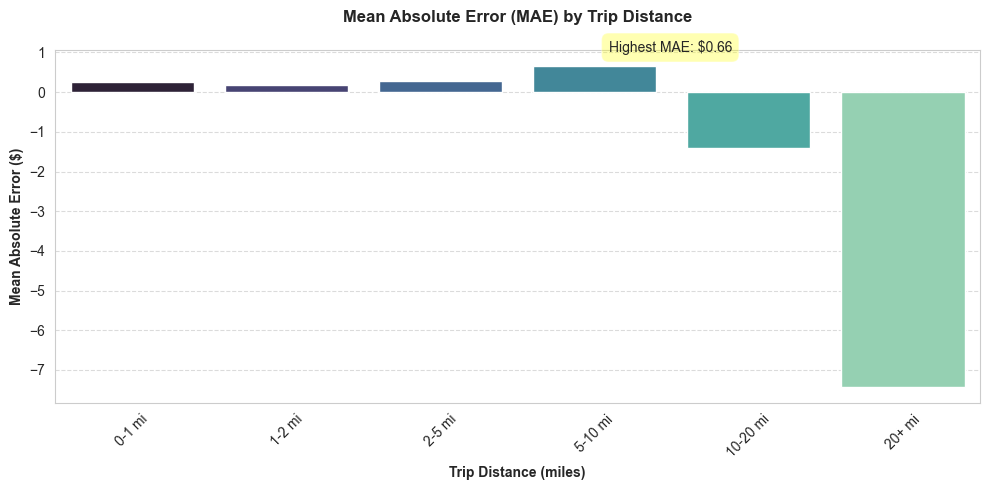

In [93]:
# Bin trip distances into logical groups
bins = [0, 1, 2, 5, 10, 20, np.inf]
labels = ['0-1 mi', '1-2 mi', '2-5 mi', '5-10 mi', '10-20 mi', '20+ mi']
full_results['distance_bin'] = pd.cut(
    full_results['trip_distance'], 
    bins=bins, 
    labels=labels
)

# Calculate Mean Absolute Error (MAE) per distance bin
dist_mae = full_results.groupby('distance_bin')['error'].mean().reset_index()

# Plot MAE by trip distance
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x='distance_bin', 
    y='error', 
    data=dist_mae, 
    palette='mako',
    ci=None  # Remove confidence intervals if not needed
)

# Formatting for clarity
plt.title('Mean Absolute Error (MAE) by Trip Distance', fontweight='bold', pad=20)
plt.xlabel('Trip Distance (miles)', fontweight='bold')
plt.ylabel('Mean Absolute Error ($)', fontweight='bold')
plt.xticks(rotation=45)  # Improve readability of x-labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Light gridlines for reference

# Highlight key insights (e.g., MAE trends)
max_mae_bin = dist_mae.loc[dist_mae['error'].idxmax()]
ax.annotate(
    f'Highest MAE: ${abs(max_mae_bin["error"]):.2f}', 
    xy=(max_mae_bin.name, max_mae_bin['error']), 
    xytext=(10, 10), 
    textcoords='offset points',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3),
    arrowprops=dict(arrowstyle='->')
)

plt.tight_layout()  # Prevent label cutoff
plt.show()

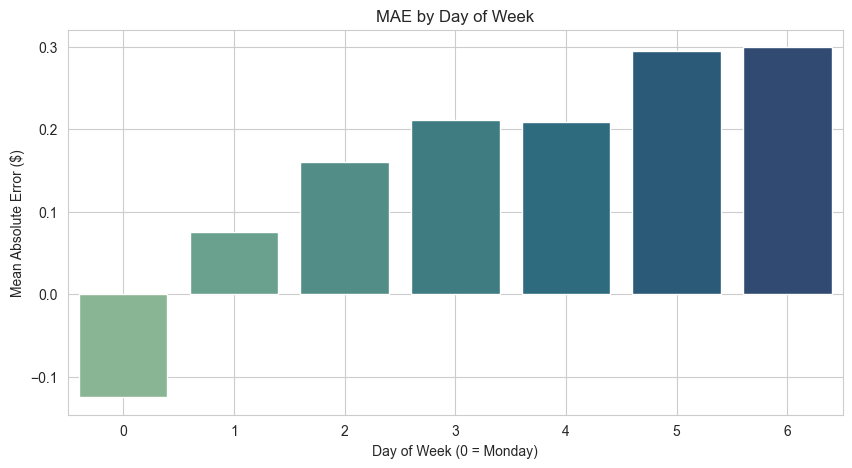

In [91]:
dow_mae = full_results.groupby('pickup_dayofweek')['error'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='pickup_dayofweek', y='error', data=dow_mae, palette='crest')
plt.title('MAE by Day of Week')
plt.xlabel('Day of Week (0 = Monday)')
plt.ylabel('Mean Absolute Error ($)')
plt.grid(True)
plt.show()


In [ ]:
#Save Final Model for Deployment
model_v1.save("final_taxi_fare_model.keras")  # or .h5


In [94]:
#To load later:
from tensorflow.keras.models import load_model
loaded_model = load_model("final_taxi_fare_model.keras")


#####